SC_SP Âª∂ÈÅ≤‰πãÁ≠ñÁï•Ë®≠Ë®à

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice
from datetime import datetime, timedelta
import re
import os
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties as font
import matplotlib
matplotlib.rc('font', family='Microsoft JhengHei') # Âú®ÂúñË°®‰∏äÈ°ØÁ§∫‰∏≠Êñá
import matplotlib.ticker as mtick
from collections import Counter

In [139]:
def load_data(pcp_path1, pcp_path2):
    """ ËÆÄÂèñPCPË≥áÊñô+ÊØèÊó•Êó•ÂÖßtickË≥áÊñô """
    df_pcp1 = pd.read_csv(pcp_path1, encoding='utf-8', low_memory = False)
    df_pcp2 = pd.read_csv(pcp_path2, encoding='utf-8', low_memory = False)

    # Âêà‰ΩµÂÖ©ÂÄã DataFrame
    df_pcp = pd.concat([df_pcp1, df_pcp2], ignore_index=True)

    return df_pcp


def commodityid_time(year, target_month):
    """
    Ëá™ÂãïÂà§Êñ∑ÊúüË≤®ËàáÈÅ∏ÊìáÊ¨äÂïÜÂìÅ‰ª£Á¢ºÔºåËß£Ê±∫Ë∑®Âπ¥ (12 Êúà & 1 Êúà) ÁöÑÂïèÈ°å
    """
    month_code = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L"]
    put_code = ["M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X"]
    
    # ÂèñÂæóÂπ¥‰ªΩÁöÑÊúÄÂæå‰∏Ä‰ΩçÊï∏ (e.g., 2024 -> "4")
    year_short = str(year)[-1]

    # Ë®àÁÆóÁõÆÊ®ôÂà∞ÊúüÊúà‰ªΩÁöÑÁ¥¢Âºï
    target_month_idx = target_month - 1  # Á¥¢ÂºïÂæû 0 ÈñãÂßã
    
    # ÁîüÊàêÂïÜÂìÅ‰ª£Á¢º
    call_codes = [f"{month_code[target_month_idx]}{year_short}"]
    put_codes = [f"{put_code[target_month_idx]}{year_short}"]
    code =  'MXF' + month_code[target_month_idx] + year_short

    return call_codes, put_codes, code

def preprocess_pcp(df_pcp, call_codes, put_codes):
    """
    1. ËΩâÊèõ TradeTime Ê†ºÂºè
    2. ÂçÄÂàÜ Call„ÄÅPut„ÄÅÊúüË≤®
    3. Á¥ÄÈåÑ BS (Ë≤∑Ë≥£ÊñπÂêë)
    """
    
    df_pcp = df_pcp.copy() # ÂâµÂª∫ÂâØÊú¨Ôºå‰∏çÂΩ±ÈüøÂéüÊú¨Êï∏Êìö
    df_pcp['TradeTime'] = pd.to_datetime(df_pcp['TradeTime']) # Á¢∫‰øùÊôÇÈñìÁÇ∫ datetime64
    df_pcp['CommodityId'] = df_pcp['CommodityId'].astype(str) # Á¢∫‰øù‰ª£Á¢ºÁÇ∫ string

    # Ëæ®Âà•call, put, fut‰ª•ÂèäÂàÜÁæ§ÔºåCALLËàáPUT‰∏ªË¶Å‰ª•ÂïÜÂìÅÂæåÂÖ©Á¢ºÂéªË≠òÂà•ÔºåFUTÂâáÊòØÈéñÂÆöMXFÂéªË≠òÂà•
    df_call = df_pcp[(df_pcp['CommodityId'].str[-2:].isin(call_codes)) & (~df_pcp['CommodityId'].str.startswith('MXF'))].copy() # CallÁöÑÈÉ®ÂàÜÂõ†ÁÇ∫ÂïÜÂìÅÂæåÂÖ©Á¢ºËàáÊúüË≤®Áõ∏ÂêåÔºåÊâÄ‰ª•ÊúÄÂæåÈúÄÂéªÈô§ÊúüË≤®Êï∏Êìö
    df_put = df_pcp[df_pcp['CommodityId'].str[-2:].isin(put_codes)].copy()
    df_fut = df_pcp[df_pcp['CommodityId'].str.startswith('MXF')].copy()
    
    return df_call, df_put, df_fut


def get_strike_price(option_id):
    """
    ÂæûÈÅ∏ÊìáÊ¨ä‰ª£Á¢ºÊèêÂèñÂ±•Á¥ÑÂÉπÔºåex:TXO23000j4‰∏≠ÂèñÂá∫23000
    """
    try:
        return int(option_id[3:8])
    except ValueError:
        return None
    

def construct_pcp(df_call, df_put, df_fut):
    """
    ÈÄèÈÅéÊôÇÈñìÂ∫èÂàóÊâæÂá∫ÊúÄËøëÁöÑ Call„ÄÅPut„ÄÅÊúüË≤® (MXF) ÁµÑÊàê PCPÔºå‰∏¶Ëß£Ê±∫Êï∏ÊìöÂÅèÂ∑ÆËàáÈáçË§áÊäìÂèñÂïèÈ°å
    """

    # Â∞áCall, Put, FutÊåâÁÖßTradeTimeÊéíÂ∫è(Áî±Â∞èÂà∞Â§ß)
    df_call = df_call.sort_values(by="TradeTime").copy()
    df_put = df_put.sort_values(by="TradeTime").copy()
    df_fut = df_fut.sort_values(by="TradeTime").copy()
    
    pcp_list = []  # ÂÑ≤Â≠ò PCP ÁµÑÂêà
    
    # ‰ª•CallÁÇ∫Âü∫Ê∫ñÂéªÊäìÂ±•Á¥ÑÂÉπÔºå‰∏¶ÂéªMapping Put, Fut ÁöÑË≥áÊñôÔºåÁµÑÊàêPCP
    for _, call_row in df_call.iterrows(): # ÂøΩÁï•indexÂÄº
        call_time = call_row['TradeTime'] 
        call_price = call_row['Price']
        call_id = call_row['CommodityId']
        call_fee = call_row['Fee']
        call_bs = call_row['BS']
        strike_price = get_strike_price(call_id)
        
        if strike_price is None:
            continue

        # Á¢∫‰øù Call„ÄÅPut Â±•Á¥ÑÂÉπÁõ∏ÂêåÔºåÂ¶ÇÊûúPutÂ∞ç‰∏ç‰∏äCallÔºåÂâáÁßªÈô§Ê≠§Á≠ÜË≥áÊñô
        put_candidates = df_put[df_put['CommodityId'].apply(get_strike_price) == strike_price]
        put_candidates = put_candidates.dropna(subset=['TradeTime'])
        put_candidates['TradeTime'] = pd.to_datetime(put_candidates['TradeTime'])

        # ÊâæÊúÄÊé•ËøëÁöÑ PutÔºåË®≠ÂÆöËàáCallÊôÇÈñìÂ∑ÆÈúÄ <= 5ÂàÜÈêò
        put_row = put_candidates.iloc[(put_candidates['TradeTime'] - call_time).abs().argsort()[:1]] # Ë®àÁÆóÊØèÂÄãTradeTime PutËàáCallÂ∑ÆË∑ùÔºå‰∏¶ÊâæÂ∞ãÊôÇÈñìÂ∑ÆÊúÄÂ∞èÁöÑÂ≠òÂÖ•put_row
        if put_row.empty or abs(put_row['TradeTime'].values[0] - call_time) > timedelta(minutes=5): # Â¶ÇÊûúÊâæ‰∏çÂà∞orÊôÇÈñìÂ∑ÆÂ§ßÊñº5ÂàÜÈêòÂç≥ÂøΩÁï•
            continue


        put_time = put_row['TradeTime'].values[0] # ÈÄèÈÅévalues[0]ËΩâÊèõ Pandas Series to NumPy (ÊØèÂÄãPandas Series ‰πüÂÉÖÊúâÂîØ‰∏ÄÂÄº)
        put_price = put_row['Price'].values[0]
        put_id = put_row['CommodityId'].values[0]
        put_fee = put_row['Fee'].values[0]
        put_bs = put_row['BS'].values[0]
        
        # ÊâæÊúÄÊé•ËøëÁöÑ FutureÔºåË®≠ÂÆöËàáCallÊôÇÈñìÂ∑ÆÈúÄ <= 5ÂàÜÈêò
        fut_row = df_fut.iloc[(df_fut['TradeTime'] - call_time).abs().argsort()[:1]]
        if fut_row.empty or abs(fut_row['TradeTime'].values[0] - call_time) > timedelta(minutes=5):
            continue
        
        fut_time = fut_row['TradeTime'].values[0]
        fut_price = fut_row['Price'].values[0]
        fut_id = fut_row['CommodityId'].values[0]
        fut_fee = fut_row['Fee'].values[0]
        fut_bs = fut_row['BS'].values[0]
        
        # Ë®àÁÆó‰∫§ÊòìÊàêÊú¨ËàáÊâãÁ∫åË≤ª
        total_fee = call_fee + put_fee + fut_fee 

        # Áµ±Êï¥Êàê PCP Ë≥áË®ä‰∏ÄË¶Ω List
        pcp = {
            "TradeTime": call_time,
            "StrikePrice":strike_price,
            "FuturePrice": fut_price,
            "FutureID": fut_id,
            "FutureBS": fut_bs,
            "FutureFee": fut_fee,
            "CallPrice": call_price,
            "CallID": call_id,
            "CallBS": call_bs,
            "CallFee": call_fee,
            "PutPrice": put_price,
            "PutID": put_id,
            "PutBS": put_bs,
            "PutFee": put_fee,
            "Fee": total_fee,
            "CallTime": call_time,
            "PutTime": put_time,
            "FutTime": fut_time
        }
        pcp_list.append(pcp)

    df_pcp_final = pd.DataFrame(pcp_list)
    return df_pcp_final

def calculate_fees(df):
    """ 
    Ëá™Ë°åË®àÁÆóË≤ªÁî®ËàáÁ®Ö
    1. Á®ÖÔºö
    Â∞èÂè∞ 0.00002*50
    ÈÅ∏ÊìáÊ¨ä 0.001*50
    2. ÊâãÁ∫åË≤ªÔºö
    Â∞èÂè∞‰∏ÄÂè£13.3ÂÖÉ
    ÈÅ∏ÊìáÊ¨ä‰∏ÄÂè£10.8ÂÖÉ
    Ë≤∑Ë≥£ÈÉΩË¶ÅÁ®Ö&Ë≤ª

    Áî±ÊñºÊï∏ÊìöÈô≥ÂàóÊôÇÂ∞±ÊòØÂ∞áÊØèÁ≠ÜÊï∏ÊìöÈÉΩÁç®Á´ãÈñã‰æÜÔºåÂõ†Ê≠§ÂèØËÉΩÊúÉÂ∞èÂπÖ‰Ωé‰º∞/È´ò‰º∞Á∏ΩËä±Ë≤ª
    """
    df["FutureTax"] = round(df["FuturePrice"] * 0.00002 * 50,0)
    df["FutureFee"] = round(13.3,0)

    df["CallTax"] = round(df["CallPrice"] * 0.001 * 50,0)
    df["CallFee"] = round(10.8,0) 

    df["PutTax"] = round(df["PutPrice"] * 0.001 * 50,0)
    df["PutFee"] = round(10.8,0)  # Ë≤∑Ë≥£ÁöÜÈúÄÊâãÁ∫åË≤ª

    # Ë®àÁÆóÁ∏Ω‰∫§ÊòìË≤ªÁî® 
    df["NewFee"] = df["FutureTax"] + df["FutureFee"] + df["CallTax"] + df["CallFee"] + df["PutTax"] + df["PutFee"]

    return df


def convert_time_format(df):
    """ 
    ËΩâÊèõÊôÇÈñìÊ†ºÂºèÔºåÂ∞á TradeTime ÂàÜÊãÜÁÇ∫ Date Âíå Time 
    """
    trade_d = []
    trade_t = []
    
    for t in df['TradeTime']:
        dt = datetime.strptime(str(t), "%Y-%m-%d %H:%M:%S")  # Á¢∫‰øù TradeTime Ê†ºÂºèÊ≠£Á¢∫Ëß£Êûê
        trade_d.append(dt.strftime("%Y%m%d"))  # ÊèêÂèñÊó•ÊúüÔºåÊ†ºÂºè YYYYMMDD
        trade_t.append(dt.strftime("%H%M%S"))  # ÊèêÂèñÊôÇÈñìÔºåÊ†ºÂºè HHMMSS
    
    df['Date'] = trade_d  # Êñ∞Â¢û Date Ê¨Ñ‰Ωç
    df['Time'] = trade_t  # Êñ∞Â¢û Time Ê¨Ñ‰Ωç
    
    return df


def split_datetime_column_and_clean(df, column_name):
    """ 
    Â∞áÊåáÂÆö‰ª• Time ÁµêÂ∞æÁöÑÊ¨Ñ‰ΩçÂàÜÊãÜÁÇ∫ÂÆ¢Ë£ΩÂåñÁöÑ Time Ê¨Ñ‰Ωç
    """
    if column_name not in df.columns:
        raise ValueError(f"Ê¨Ñ‰Ωç '{column_name}' ‰∏çÂ≠òÂú®Êñº DataFrame ‰∏≠")

    # ÂéªÈô§ 'Time' ÂæåÁ∂¥‰ΩúÁÇ∫Âü∫Â∫ïÂêçÁ®±
    base_column_name = column_name[:-4]  # ÁßªÈô§ 'Time'

    # Ëá™Ë®ÇÁîüÊàêÁöÑÊ¨Ñ‰ΩçÂêçÁ®±
    time_column_name = f"{base_column_name}_Time"

    # Áî®ÊñºÂ≠òÊîæÂàÜÊãÜÁµêÊûúÁöÑÂàóË°®
    time_list = []

    for t in df[column_name]:
        # Á¢∫‰øùÊ¨Ñ‰ΩçÂÄºË¢´Ê≠£Á¢∫Ëß£ÊûêÁÇ∫ datetime Ê†ºÂºè
        dt = datetime.strptime(str(t), "%Y-%m-%d %H:%M:%S")
        time_list.append(dt.strftime("%H%M%S"))  # ÊèêÂèñÊôÇÈñìÔºåÊ†ºÂºè HHMMSS

    # Êñ∞Â¢ûÂÆ¢Ë£ΩÂåñÁöÑ Time Ê¨Ñ‰Ωç
    df[time_column_name] = time_list
    
    return df

def df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time, end_time):
    """
    ËÆÄÂèñ PCP Ë≥áÊñôÔºåÈÅéÊøæÊåáÂÆöÊúà‰ªΩÊï∏ÊìöÔºå‰∏¶‰æùÁÖßË®≠ÂÆöÊôÇÈñìÁØÑÂúç (`start_time` ~ `end_time`) ÁØ©ÈÅ∏Ë≥áÊñô
    """
    df_pcp = load_data(pcp_path1, pcp_path2)
    call_codes, put_codes, code = commodityid_time(year, month)
    df_call, df_put, df_fut = preprocess_pcp(df_pcp, call_codes, put_codes)
    df_final_pcp = construct_pcp(df_call, df_put, df_fut)
    df_final_pcp = convert_time_format(df_final_pcp)
    df_final_pcp = split_datetime_column_and_clean(df_final_pcp, 'CallTime')
    df_final_pcp = split_datetime_column_and_clean(df_final_pcp, 'PutTime')
    df_final_pcp = split_datetime_column_and_clean(df_final_pcp, 'FutTime')
    df_final_pcp = calculate_fees(df_final_pcp)
    
    # ÈÅéÊøæÊúüË≤®‰ª£Á¢º
    df_final_pcp = df_final_pcp[df_final_pcp['FutureID'] == code]

    # **Êñ∞Â¢ûÊôÇÈñìÁØÑÂúçÈÅéÊøæ**
    df_final_pcp = df_final_pcp[
        (df_final_pcp['Time'].astype(int) >= start_time) & 
        (df_final_pcp['Time'].astype(int) <= end_time)
    ]

    return df_final_pcp


In [196]:
def load_tick_data(tick_folder, files):
    """ ËÆÄÂèñPCPË≥áÊñô+ÊØèÊó•Êó•ÂÖßtickË≥áÊñô """
    df_list = [pd.read_csv(f"{tick_folder}/2025_{f[:-4]}.csv", encoding='cp950', low_memory=False) for f in files]
    combined_df = pd.concat(df_list, ignore_index=True)  # Âêà‰ΩµÂ§öÂÄã DataFrame
    
    # ÁØ©ÈÅ∏Âá∫ÁõÆÊ®ôÊúà‰ªΩÁöÑË≥áÊñôÔºåÂêåÊôÇÊéíÈô§ IV = 9999ÁöÑÊï∏Êìö
    filtered_df = combined_df[combined_df['IV'] != 9999]
    
    return filtered_df

def filter_by_month(df, year, target_month):
    """
    Ê†πÊìöÊåáÂÆöÂπ¥‰ªΩËàáÊúà‰ªΩÁØ©ÈÅ∏Ë≥áÊñôÔºåÂè™‰øùÁïôË©≤ÊúàË≥áÊñô
    """
    df['Êàê‰∫§Êó•Êúü'] = pd.to_datetime(df['Êàê‰∫§Êó•Êúü'], format='%Y%m%d')

    # Âª∫Á´ãÁï∂ÊúàÁöÑËµ∑ÂßãËàáÁµêÊùüÊó•Êúü (Â¶Ç: 10Êúà ‚Üí 9/1 ~ 11/1)
    if target_month == 1:
        start_date = pd.Timestamp(year=year - 1, month=12, day=1)
    else:
        start_date = pd.Timestamp(year=year, month=target_month - 1, day=1)

    if target_month == 12:
        end_date = pd.Timestamp(year=year + 1, month=1, day=1)
    else:
        end_date = pd.Timestamp(year=year, month=target_month + 1, day=1)

    # ÁØ©ÈÅ∏Ë©≤Êúà‰ªΩÁöÑË≥áÊñô
    filtered_df = df[(df['Êàê‰∫§Êó•Êúü'] >= start_date) & (df['Êàê‰∫§Êó•Êúü'] <= end_date)]
    return filtered_df

def convert_buy_sell(df):
    """
    Â∞áË≤∑Ë≥£Ê¨äÂà•Ê¨Ñ‰ΩçËΩâÊèõÁÇ∫ 'C' (Ë≤∑Ê¨ä) Êàñ 'P' (Ë≥£Ê¨ä)
    """
    df = df.copy()
    df['Ë≤∑Ë≥£Ê¨äÂà•'] = df['Ë≤∑Ë≥£Ê¨äÂà•'].replace({1: 'C', 0: 'P'})
    return df

def option_tick_data(tick_folder, files, year, month, start_time, end_time):
    """
    ËÆÄÂèñ Tick Êï∏ÊìöÔºå‰∏¶Ê†πÊìö:
    - ÊåáÂÆöÊúà‰ªΩ
    - ÊåáÂÆöÊôÇÈñìÁØÑÂúç (start_time Âà∞ end_time)
    ÈÄ≤Ë°åÈÅéÊøæ
    """
    df = load_tick_data(tick_folder, files)
    filtered_df = filter_by_month(df, year, month)
    df_tick = convert_buy_sell(filtered_df)

    # ËΩâÊèõÊó•ÊúüÊ†ºÂºèÔºåÁØ©ÈÅ∏ÁâπÂÆöÂà∞ÊúüÊúà‰ªΩ
    date = f"{year}{month:02d}"
    df_tick = df_tick[df_tick["Âà∞ÊúüÊúà‰ªΩ(ÈÄ±Âà•)"] == date]

    # **Âä†ÂÖ•ÊôÇÈñìÁØ©ÈÅ∏**
    df_tick = df_tick[(df_tick['Êàê‰∫§ÊôÇÈñì'] >= start_time) & (df_tick['Êàê‰∫§ÊôÇÈñì'] <= end_time)]

    return df_tick

Áµ¶1ÊúàÁöÑ

In [157]:
def load_tick_data(tick_folder1, tick_folder2, files1, files2):
    """ ËÆÄÂèñPCPË≥áÊñô+ÊØèÊó•Êó•ÂÖßtickË≥áÊñô """
    df_list_1 = [pd.read_csv(f"{tick_folder1}/2024_{f[:-4]}.csv", encoding='cp950', low_memory=False) for f in files1]
    df_list_2 = [pd.read_csv(f"{tick_folder2}/2025_{f[:-4]}.csv", encoding='cp950', low_memory=False) for f in files2]
    combined_df = pd.concat(df_list_1 + df_list_2, ignore_index=True)  # Âêà‰ΩµÂ§öÂÄã DataFrame
    
    # ÁØ©ÈÅ∏Âá∫ÁõÆÊ®ôÊúà‰ªΩÁöÑË≥áÊñôÔºåÂêåÊôÇÊéíÈô§ IV = 9999ÁöÑÊï∏Êìö
    filtered_df = combined_df[combined_df['IV'] != 9999]
    
    return filtered_df

def filter_by_month(df, year, target_month):
    """
    Ê†πÊìöÊåáÂÆöÂπ¥‰ªΩËàáÊúà‰ªΩÁØ©ÈÅ∏Ë≥áÊñôÔºåÂè™‰øùÁïôË©≤ÊúàË≥áÊñô
    """
    df['Êàê‰∫§Êó•Êúü'] = pd.to_datetime(df['Êàê‰∫§Êó•Êúü'], format='%Y%m%d')

    # Âª∫Á´ãÁï∂ÊúàÁöÑËµ∑ÂßãËàáÁµêÊùüÊó•Êúü (Â¶Ç: 10Êúà ‚Üí 9/1 ~ 11/1)
    if target_month == 1:
        start_date = pd.Timestamp(year=year - 1, month=12, day=1)
    else:
        start_date = pd.Timestamp(year=year, month=target_month - 1, day=1)

    if target_month == 12:
        end_date = pd.Timestamp(year=year + 1, month=1, day=1)
    else:
        end_date = pd.Timestamp(year=year, month=target_month + 1, day=1)

    # ÁØ©ÈÅ∏Ë©≤Êúà‰ªΩÁöÑË≥áÊñô
    filtered_df = df[(df['Êàê‰∫§Êó•Êúü'] >= start_date) & (df['Êàê‰∫§Êó•Êúü'] <= end_date)]
    return filtered_df

def convert_buy_sell(df):
    """
    Â∞áË≤∑Ë≥£Ê¨äÂà•Ê¨Ñ‰ΩçËΩâÊèõÁÇ∫ 'C' (Ë≤∑Ê¨ä) Êàñ 'P' (Ë≥£Ê¨ä)
    """
    df = df.copy()
    df['Ë≤∑Ë≥£Ê¨äÂà•'] = df['Ë≤∑Ë≥£Ê¨äÂà•'].replace({1: 'C', 0: 'P'})
    return df

def option_tick_data(tick_folder1, tick_folder2, files1, files2, year, month, start_time, end_time):
    """
    ËÆÄÂèñ Tick Êï∏ÊìöÔºå‰∏¶Ê†πÊìö:
    - ÊåáÂÆöÊúà‰ªΩ
    - ÊåáÂÆöÊôÇÈñìÁØÑÂúç (start_time Âà∞ end_time)
    ÈÄ≤Ë°åÈÅéÊøæ
    """
    df = load_tick_data(tick_folder1, tick_folder2, files1, files2)
    filtered_df = filter_by_month(df, year, month)
    df_tick = convert_buy_sell(filtered_df)

    # ËΩâÊèõÊó•ÊúüÊ†ºÂºèÔºåÁØ©ÈÅ∏ÁâπÂÆöÂà∞ÊúüÊúà‰ªΩ
    date = f"{year}{month:02d}"
    df_tick = df_tick[df_tick["Âà∞ÊúüÊúà‰ªΩ(ÈÄ±Âà•)"] == date]

    # **Âä†ÂÖ•ÊôÇÈñìÁØ©ÈÅ∏**
    df_tick = df_tick[(df_tick['Êàê‰∫§ÊôÇÈñì'] >= start_time) & (df_tick['Êàê‰∫§ÊôÇÈñì'] <= end_time)]

    return df_tick

### Ëº∏ÂÖ•‰πã‰∏çÂêåÊúà‰ªΩ

In [677]:
# 1ÊúàÂà∞Êúü
pcp_path = r'C:/Users/ptdintern1.fut/Desktop/new_code/Jan pcp.csv'
tick_folder = r'D:/Greek/2024'
files = ['01_02.csv', '01_03.csv','01_04.csv', '01_05.csv', '01_08.csv',
         '01_09.csv', '01_10.csv','01_11.csv', '01_12.csv', '01_15.csv',
         '01_16.csv', '01_17.csv','01_18.csv' ,'01_19.csv' ,'01_22.csv',
         '01_23.csv','01_24.csv','01_25.csv','01_26.csv','01_29.csv',
         '01_30.csv','01_31.csv']

year = 2024
month = 1

start_time1 = 30000  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì (3:00)
end_time1 = 50000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì (5:00)

start_time2 = 84500  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì
end_time2 = 90000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì

settlement_price=17167

df_pcp = df_origin_pcp_mapping(pcp_path, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

KeyboardInterrupt: 

In [135]:
# 2ÊúàÂà∞Êúü
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Jan pcp.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Feb pcp.csv'
tick_folder = r'D:/Greek/2024'
files1 = ['01_02.csv', '01_03.csv','01_04.csv', '01_05.csv', '01_08.csv',
         '01_09.csv', '01_10.csv','01_11.csv', '01_12.csv', '01_15.csv',
         '01_16.csv', '01_17.csv','01_18.csv' ,'01_19.csv' ,'01_22.csv',
         '01_23.csv','01_24.csv','01_25.csv','01_26.csv','01_29.csv',
         '01_30.csv','01_31.csv']

files2 = ['02_01.csv', '02_02.csv','02_05.csv', '02_15.csv', '02_16.csv',
         '02_19.csv', '02_20.csv','02_21.csv', '02_22.csv', '02_23.csv',
         '02_26.csv', '02_27.csv','02_29.csv']

files = files1 + files2

year = 2024
month = 2

start_time1 = 30000  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì (3:00)
end_time1 = 50000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì (5:00)

start_time2 = 84500  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì
end_time2 = 90000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì

settlement_price=18670

df_pcp = df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

In [33]:
# 3ÊúàÂà∞Êúü
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Feb pcp.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Mar pcp.csv'
tick_folder = r'D:/Greek/2024'
files1 = ['02_01.csv', '02_02.csv','02_05.csv', '02_15.csv', '02_16.csv',
         '02_19.csv', '02_20.csv','02_21.csv', '02_22.csv', '02_23.csv',
         '02_26.csv', '02_27.csv','02_29.csv']

files2 = ['03_01.csv', '03_04.csv','03_05.csv', '03_06.csv', '03_07.csv',
         '03_08.csv', '03_11.csv','03_12.csv', '03_13.csv', '03_14.csv',
         '03_15.csv', '03_18.csv','03_19.csv', '03_20.csv', '03_21.csv', 
         '03_22.csv', '03_25.csv','03_26.csv', '03_27.csv', '03_28.csv',
         '03_29.csv']

files = files1 + files2

year = 2024
month = 3

start_time1 = 30000  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì (3:00)
end_time1 = 50000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì (5:00)

start_time2 = 84500  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì
end_time2 = 90000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì

settlement_price=19747

df_pcp = df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

In [447]:
# 4ÊúàÂà∞Êúü
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Mar pcp.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Apr pcp.csv'
tick_folder = r'D:/Greek/2024'
files1 = ['03_01.csv', '03_04.csv','03_05.csv', '03_06.csv', '03_07.csv',
         '03_08.csv', '03_11.csv','03_12.csv', '03_13.csv', '03_14.csv',
         '03_15.csv', '03_18.csv','03_19.csv', '03_20.csv', '03_21.csv', 
         '03_22.csv', '03_25.csv','03_26.csv', '03_27.csv', '03_28.csv',
         '03_29.csv']

files2 = ['04_01.csv', '04_02.csv','04_03.csv', '04_08.csv', '04_09.csv',
         '04_10.csv', '04_11.csv','04_12.csv', '04_15.csv', '04_16.csv',
         '04_17.csv', '04_18.csv','04_19.csv', '04_22.csv', '04_23.csv', 
         '04_24.csv', '04_25.csv','04_26.csv', '04_29.csv', '04_30.csv']

files = files1 + files2

year = 2024
month = 4

start_time1 = 30000  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì (3:00)
end_time1 = 50000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì (5:00)

start_time2 = 84500  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì
end_time2 = 90000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì

settlement_price=20238

df_pcp = df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

In [426]:
# 5ÊúàÂà∞Êúü
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Apr pcp.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/May pcp.csv'
tick_folder = r'D:/Greek/2024'
files1 = ['04_01.csv', '04_02.csv','04_03.csv', '04_08.csv', '04_09.csv',
         '04_10.csv', '04_11.csv','04_12.csv', '04_15.csv', '04_16.csv',
         '04_17.csv', '04_18.csv','04_19.csv', '04_22.csv', '04_23.csv', 
         '04_24.csv', '04_25.csv','04_26.csv', '04_29.csv', '04_30.csv']

files2 = ['05_02.csv', '05_03.csv','05_06.csv', '05_07.csv', '05_08.csv',
         '05_09.csv', '05_10.csv','05_13.csv', '05_14.csv', '05_15.csv',
         '05_16.csv', '05_17.csv','05_20.csv', '05_21.csv', '05_22.csv', 
         '05_23.csv', '05_24.csv','05_27.csv', '05_28.csv', '05_29.csv',
         '05_30.csv', '05_31.csv']

files = files1 + files2

year = 2024
month = 5

start_time1 = 30000  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì (3:00)
end_time1 = 50000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì (5:00)

start_time2 = 84500  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì
end_time2 = 90000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì

settlement_price=21144

df_pcp = df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

In [382]:
# 6ÊúàÂà∞Êúü
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/May pcp.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/June pcp.csv'
tick_folder = r'D:/Greek/2024'
files1 = ['05_02.csv', '05_03.csv','05_06.csv', '05_07.csv', '05_08.csv',
         '05_09.csv', '05_10.csv','05_13.csv', '05_14.csv', '05_15.csv',
         '05_16.csv', '05_17.csv','05_20.csv', '05_21.csv', '05_22.csv', 
         '05_23.csv', '05_24.csv','05_27.csv', '05_28.csv', '05_29.csv',
         '05_30.csv', '05_31.csv']

files2 = ['06_03.csv', '06_04.csv','06_05.csv', '06_06.csv', '06_07.csv',
         '06_11.csv', '06_12.csv','06_13.csv', '06_14.csv',
         '06_17.csv', '06_18.csv','06_19.csv', '06_20.csv', '06_21.csv', 
         '06_24.csv', '06_25.csv','06_26.csv', '06_27.csv', '06_28.csv']

files = files1 + files2

year = 2024
month = 6

start_time1 = 30000  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì (3:00)
end_time1 = 50000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì (5:00)

start_time2 = 84500  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì
end_time2 = 90000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì

settlement_price=23228

df_pcp = df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

In [202]:
# 7ÊúàÂà∞Êúü
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/June pcp.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/July pcp.csv'
tick_folder = r'D:/Greek/2024'
files1 = ['06_03.csv', '06_04.csv','06_05.csv', '06_06.csv', '06_07.csv',
         '06_11.csv', '06_12.csv','06_13.csv', '06_14.csv',
         '06_17.csv', '06_18.csv','06_19.csv', '06_20.csv', '06_21.csv', 
         '06_24.csv', '06_25.csv','06_26.csv', '06_27.csv', '06_28.csv']

files2 = ['07_01.csv', '07_02.csv', '07_03.csv', '07_04.csv', '07_05.csv',
         '07_08.csv', '07_09.csv', '07_10.csv', '07_11.csv', '07_12.csv',
         '07_15.csv', '07_16.csv', '07_17.csv', '07_18.csv', '07_19.csv',
         '07_22.csv', '07_23.csv', '07_26.csv', '07_29.csv', '07_30.csv', '07_31.csv']

files = files1 + files2

year = 2024
month = 7

start_time1 = 30000  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì (3:00)
end_time1 = 50000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì (5:00)

start_time2 = 84500  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì
end_time2 = 90000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì

settlement_price=23680

df_pcp = df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

In [186]:
# 8ÊúàÂà∞Êúü
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Aug pcp.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/July pcp.csv'
tick_folder = r'D:/Greek/2024'
files1 = ['07_01.csv', '07_02.csv', '07_03.csv', '07_04.csv', '07_05.csv',
         '07_08.csv', '07_09.csv', '07_10.csv', '07_11.csv', '07_12.csv',
         '07_15.csv', '07_16.csv', '07_17.csv', '07_18.csv', '07_19.csv',
         '07_22.csv', '07_23.csv', '07_26.csv', '07_29.csv', '07_30.csv', '07_31.csv']

files2 = ['08_01.csv', '08_02.csv',
         '08_05.csv', '08_06.csv', '08_07.csv', '08_08.csv', '08_09.csv',
         '08_12.csv', '08_13.csv', '08_14.csv', '08_15.csv', '08_16.csv',
         '08_19.csv', '08_20.csv', '08_21.csv', '08_22.csv', '08_23.csv',
         '08_26.csv', '08_27.csv', '08_28.csv', '08_29.csv', '08_30.csv']

files = files1 + files2

year = 2024
month = 8

start_time1 = 30000  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì (3:00)
end_time1 = 50000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì (5:00)

start_time2 = 84500  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì
end_time2 = 90000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì

settlement_price=22200

df_pcp = df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

In [230]:
# 9ÊúàÂà∞Êúü
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Sep pcp.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Aug pcp.csv'
tick_folder = r'D:/Greek/2024'
files2 = ['09_02.csv', '09_03.csv', '09_04.csv', '09_05.csv', '09_06.csv',
         '09_09.csv', '09_10.csv', '09_11.csv', '09_12.csv', '09_13.csv',
         '09_16.csv', '09_18.csv', '09_19.csv', '09_20.csv',
         '09_23.csv', '09_24.csv', '09_25.csv', '09_26.csv', '09_27.csv','09_30.csv',
]

files1 = ['08_01.csv', '08_02.csv',
         '08_05.csv', '08_06.csv', '08_07.csv', '08_08.csv', '08_09.csv',
         '08_12.csv', '08_13.csv', '08_14.csv', '08_15.csv', '08_16.csv',
         '08_19.csv', '08_20.csv', '08_21.csv', '08_22.csv', '08_23.csv',
         '08_26.csv', '08_27.csv', '08_28.csv', '08_29.csv', '08_30.csv'
]

files = files1 + files2

year = 2024
month = 9

start_time1 = 30000  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì (3:00)
end_time1 = 50000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì (5:00)

start_time2 = 84500  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì
end_time2 = 90000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì

settlement_price=21617

df_pcp = df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

In [346]:
# 10ÊúàÂà∞Êúü
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Oct pcp.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Sep pcp.csv'
tick_folder = r'D:/Greek/2024'
files1 = ['09_02.csv', '09_03.csv', '09_04.csv', '09_05.csv', '09_06.csv',
         '09_09.csv', '09_10.csv', '09_11.csv', '09_12.csv', '09_13.csv',
         '09_16.csv', '09_18.csv', '09_19.csv', '09_20.csv',
         '09_23.csv', '09_24.csv', '09_25.csv', '09_26.csv', '09_27.csv','09_30.csv',
]

files2 = ['10_01.csv', '10_04.csv',
         '10_07.csv', '10_08.csv', '10_09.csv', '10_11.csv',
         '10_14.csv', '10_15.csv', '10_16.csv', '10_17.csv', '10_18.csv',
         '10_21.csv', '10_22.csv', '10_23.csv', '10_24.csv', '10_25.csv',
         '10_28.csv', '10_29.csv', '10_30.csv'
]

files = files1 + files2

year = 2024
month = 10
start_time1 = 30000  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì (3:00)
end_time1 = 50000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì (5:00)

start_time2 = 84500  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì
end_time2 = 90000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì

settlement_price=22986

df_pcp = df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

In [304]:
# 11ÊúàÂà∞Êúü
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Oct pcp.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Nov pcp.csv'
tick_folder = r'D:/Greek/2024'
files1 = ['10_01.csv', '10_04.csv',
         '10_07.csv', '10_08.csv', '10_09.csv', '10_11.csv',
         '10_14.csv', '10_15.csv', '10_16.csv', '10_17.csv', '10_18.csv',
         '10_21.csv', '10_22.csv', '10_23.csv', '10_24.csv', '10_25.csv',
         '10_28.csv', '10_29.csv', '10_30.csv'
]

files2 = ['11_01.csv', '11_04.csv', '11_05.csv', '11_06.csv', '11_07.csv',
         '11_08.csv', '11_11.csv', '11_12.csv', '11_13.csv', '11_14.csv',
         '11_15.csv', '11_18.csv', '11_19.csv', '11_20.csv', '11_21.csv',
         '11_22.csv', '11_25.csv', '11_26.csv', '11_27.csv', '11_28.csv',
         '11_29.csv'
]

files = files1 + files2

year = 2024
month = 11
start_time1 = 30000  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì (3:00)
end_time1 = 50000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì (5:00)

start_time2 = 84500  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì
end_time2 = 90000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì

settlement_price=22686

df_pcp = df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

In [141]:
# 12ÊúàÂà∞Êúü
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Nov pcp.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Dec pcp.csv'
tick_folder = r'D:/Greek/2024'
files1 = ['11_01.csv', '11_04.csv', '11_05.csv', '11_06.csv', '11_07.csv',
         '11_08.csv', '11_11.csv', '11_12.csv', '11_13.csv', '11_14.csv',
         '11_15.csv', '11_18.csv', '11_19.csv', '11_20.csv', '11_21.csv',
         '11_22.csv', '11_25.csv', '11_26.csv', '11_27.csv', '11_28.csv',
         '11_29.csv'
]

files2 = ['12_02.csv', '12_03.csv', '12_04.csv', '12_05.csv', '12_06.csv',
         '12_09.csv', '12_10.csv', '12_11.csv', '12_12.csv', '12_13.csv',
         '12_16.csv', '12_17.csv', '12_18.csv', '12_19.csv', '12_20.csv',
         '12_23.csv', '12_24.csv', '12_25.csv', '12_26.csv', '12_27.csv',
         '12_30.csv', '12_31.csv'
]

files = files1 + files2

year = 2024
month = 12
start_time1 = 30000  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì (3:00)
end_time1 = 50000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì (5:00)

start_time2 = 84500  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì
end_time2 = 90000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì

settlement_price=23105

df_pcp = df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

In [158]:
# 2025Âπ¥1ÊúàÂà∞Êúü
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Dec pcp.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Jan pcp 2025.csv'
tick_folder1 = r'D:/Greek/2024'
tick_folder2 = r'D:/Greek/2025'
files1 = ['12_02.csv', '12_03.csv', '12_04.csv', '12_05.csv', '12_06.csv',
         '12_09.csv', '12_10.csv', '12_11.csv', '12_12.csv', '12_13.csv',
         '12_16.csv', '12_17.csv', '12_18.csv', '12_19.csv', '12_20.csv',
         '12_23.csv', '12_24.csv', '12_25.csv', '12_26.csv', '12_27.csv',
         '12_30.csv', '12_31.csv'
]

files2 = ['01_02.csv', '01_03.csv', '01_06.csv', '01_07.csv', '01_08.csv',
         '01_09.csv', '01_10.csv', '01_13.csv', '01_14.csv', '01_15.csv',
         '01_16.csv', '01_17.csv', '01_20.csv', '01_21.csv', '01_22.csv'
]

year = 2025
month = 1
start_time1 = 30000  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì (3:00)
end_time1 = 50000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì (5:00)

start_time2 = 84500  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì
end_time2 = 90000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì

settlement_price= 22519

df_pcp = df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder1, tick_folder2, files1, files2, year, month, start_time2, end_time2)

In [197]:
# 2025Âπ¥2ÊúàÂà∞Êúü
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Jan pcp 2025.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Feb pcp 2025.csv'
tick_folder = r'D:/Greek/2025'
files1 = ['01_02.csv', '01_03.csv', '01_06.csv', '01_07.csv', '01_08.csv',
         '01_09.csv', '01_10.csv', '01_13.csv', '01_14.csv', '01_15.csv',
         '01_16.csv', '01_17.csv', '01_20.csv', '01_21.csv', '01_22.csv'
]

files2 = ['02_03.csv', '02_04.csv', '02_05.csv', '02_06.csv', '02_07.csv',
         '02_10.csv', '02_11.csv', '02_12.csv', '02_13.csv', '02_14.csv',
         '02_17.csv', '02_18.csv', '02_19.csv', '02_20.csv', '02_21.csv',
         '02_24.csv', '02_25.csv', '02_26.csv', '02_27.csv',
]

files = files1 + files2

year = 2025
month = 2
start_time1 = 30000  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì (3:00)
end_time1 = 50000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì (5:00)

start_time2 = 84500  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì
end_time2 = 90000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì

settlement_price= 23608

df_pcp = df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

In [221]:
# 2025Âπ¥3ÊúàÂà∞Êúü
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Feb pcp 2025.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Mar pcp 2025.csv'
tick_folder = r'D:/Greek/2025'
files1 = ['02_03.csv', '02_04.csv', '02_05.csv', '02_06.csv', '02_07.csv',
         '02_10.csv', '02_11.csv', '02_12.csv', '02_13.csv', '02_14.csv',
         '02_17.csv', '02_18.csv', '02_19.csv', '02_20.csv', '02_21.csv',
         '02_24.csv', '02_25.csv', '02_26.csv', '02_27.csv',
]


files2 = ['03_03.csv', '03_04.csv', '03_05.csv', '03_06.csv', '03_07.csv',
         '03_10.csv', '03_11.csv', '03_12.csv', '03_13.csv', '03_14.csv',
         '03_17.csv', '03_18.csv', '03_19.csv', '03_20.csv', '03_21.csv',
         '03_24.csv', '03_25.csv', '03_26.csv', '03_27.csv', '03_28.csv',
         '03_31.csv'
]

files = files1 + files2

year = 2025
month = 3
start_time1 = 30000  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì (3:00)
end_time1 = 50000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì (5:00)

start_time2 = 84500  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì
end_time2 = 90000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì

settlement_price= 21964

df_pcp = df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

In [290]:
# 2025Âπ¥4ÊúàÂà∞Êúü
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Mar pcp 2025.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Apr pcp 2025.csv'
tick_folder = r'D:/Greek/2025'
files1 = ['03_03.csv', '03_04.csv', '03_05.csv', '03_06.csv', '03_07.csv',
         '03_10.csv', '03_11.csv', '03_12.csv', '03_13.csv', '03_14.csv',
         '03_17.csv', '03_18.csv', '03_19.csv', '03_20.csv', '03_21.csv',
         '03_24.csv', '03_25.csv', '03_26.csv', '03_27.csv', '03_28.csv',
         '03_31.csv'
]

files2 = ['04_01.csv', '04_02.csv', '04_07.csv', '04_08.csv', '04_09.csv',
         '04_10.csv', '04_11.csv', '04_14.csv', '04_15.csv', '04_16.csv',
         '04_17.csv', '04_18.csv', '04_21.csv', '04_22.csv', '04_23.csv',
]

files = files1 + files2

year = 2025
month = 4
start_time1 = 30000  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì (3:00)
end_time1 = 50000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì (5:00)

start_time2 = 84500  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì
end_time2 = 90000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì

settlement_price= 19548 # 4/16

df_pcp = df_origin_pcp_mapping(pcp_path1, pcp_path2, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

In [90]:
# ÁâπÊÆä‰∫ã‰ª∂
pcp_path1 = r'C:/Users/ptdintern1.fut/Desktop/new_code/Aug pcp.csv'
pcp_path2 = r'C:/Users/ptdintern1.fut/Desktop/new_code/July pcp.csv'
tick_folder = r'D:/Greek/2024'

files = ['08_05.csv', '08_06.csv', '08_07.csv','08_08.csv', '08_09.csv']

year = 2024
month = 8

start_time1 = 30000  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì (3:00)
end_time1 = 50000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì (5:00)

start_time2 = 84500  # Ë®≠ÂÆöËµ∑ÂßãÊôÇÈñì
end_time2 = 90000  # Ë®≠ÂÆöÁµêÊùüÊôÇÈñì

df_pcp = df_origin_pcp_mapping(pcp_path1, year, month, start_time1, end_time1)
df_tick = option_tick_data(tick_folder, files, year, month, start_time2, end_time2)

In [174]:
df_pcp 

TradeTime  StrikePrice  FuturePrice FutureID FutureBS  \
699  2025-02-22 03:20:00        24000      23492.0    MXFC5        B   
700  2025-02-22 03:20:00        23600      23492.0    MXFC5        B   
701  2025-02-22 03:20:00        22800      23492.0    MXFC5        B   
702  2025-02-22 03:20:00        23500      23492.0    MXFC5        B   
703  2025-02-22 03:20:00        23500      23492.0    MXFC5        B   
...                  ...          ...          ...      ...      ...   
3195 2025-03-18 03:28:00        22050      22408.0    MXFC5        B   
3196 2025-03-18 04:23:00        23000      22373.0    MXFC5        S   
3197 2025-03-18 04:36:00        22000      22400.0    MXFC5        S   
3312 2025-03-19 03:07:00        22550      22177.0    MXFC5        S   
3313 2025-03-19 04:40:00        22500      22166.0    MXFC5        B   

      FutureFee  CallPrice      CallID CallBS  CallFee  ...  \
699        13.0      200.0  TXO24000C5      S     11.0  ...   
700        13.0      360.0  TXO23600C5      S     11.0  ...   
701        13.0      870.0  TXO22800C5      S     11.0  ...   
702        13.0      412.0  TXO23500C5      S     11.0  ...   
703        13.0      412.0  TXO23500C5      S     11.0  ...   
...         ...        ...         ...    ...      ...  ...   
3195       13.0      403.0  TXO22050C5      S     11.0  ...   
3196       13.0        1.5  TXO23000C5      B     11.0  ...   
3197       13.0      420.0  TXO22000C5      B     11.0  ...   
3312       13.0        1.9  TXO22550C5      B     11.0  ...   
3313       13.0        1.6  TXO22500C5      S     11.0  ...   

                 FutTime      Date    Time  Call_Time  Put_Time Fut_Time  \
699  2025-02-22 03:20:00  20250222  032000     032000    032000   032000   
700  2025-02-22 03:20:00  20250222  032000     032000    032000   032000   
701  2025-02-22 03:20:00  20250222  032000     032000    032000   032000   
702  2025-02-22 03:20:00  20250222  032000     032000    032000   032000   
703  2025-02-22 03:20:00  20250222  032000     032000    032000   032000   
...                  ...       ...     ...        ...       ...      ...   
3195 2025-03-18 03:28:00  20250318  032800     032800    032800   032800   
3196 2025-03-18 04:23:00  20250318  042300     042300    042300   042300   
3197 2025-03-18 04:36:00  20250318  043600     043600    043600   043600   
3312 2025-03-19 03:07:00  20250319  030700     030700    030700   030700   
3313 2025-03-19 04:40:00  20250319  044000     044000    044000   044000   

     FutureTax CallTax PutTax NewFee  
699       23.0    10.0   35.0  103.0  
700       23.0    18.0   23.0   99.0  
701       23.0    44.0    8.0  110.0  
702       23.0    21.0   20.0   99.0  
703       23.0    21.0   20.0   99.0  
...        ...     ...    ...    ...  
3195      22.0    20.0    2.0   79.0  
3196      22.0     0.0   32.0   89.0  
3197      22.0    21.0    1.0   79.0  
3312      22.0     0.0   19.0   76.0  
3313      22.0     0.0   16.0   73.0  

[680 rows x 27 columns]

In [54]:
df_pcp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114 entries, 519 to 2144
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   TradeTime    114 non-null    datetime64[ns]
 1   StrikePrice  114 non-null    int64         
 2   FuturePrice  114 non-null    float64       
 3   FutureID     114 non-null    object        
 4   FutureBS     114 non-null    object        
 5   FutureFee    114 non-null    float64       
 6   CallPrice    114 non-null    float64       
 7   CallID       114 non-null    object        
 8   CallBS       114 non-null    object        
 9   CallFee      114 non-null    float64       
 10  PutPrice     114 non-null    float64       
 11  PutID        114 non-null    object        
 12  PutBS        114 non-null    object        
 13  PutFee       114 non-null    float64       
 14  Fee          114 non-null    float64       
 15  CallTime     114 non-null    datetime64[ns]
 16  PutTime   

In [173]:
df_tick

Êàê‰∫§Êó•Êúü     Â±•Á¥ÑÂÉπÊ†º Âà∞ÊúüÊúà‰ªΩ(ÈÄ±Âà•) Ë≤∑Ë≥£Ê¨äÂà•     Êàê‰∫§ÊôÇÈñì   Êàê‰∫§ÂÉπÊ†º  Êàê‰∫§Êï∏Èáè(B or S)  \
39015    2025-02-03  20500.0   202503    P  84500.0  158.0           1.0   
39016    2025-02-03  24000.0   202503    C  84500.0  230.0           2.0   
39017    2025-02-03  25200.0   202503    C  84500.0   68.0           1.0   
39018    2025-02-03  25000.0   202503    C  84500.0   78.0           1.0   
39019    2025-02-03  24500.0   202503    C  84500.0  135.0           1.0   
...             ...      ...      ...  ...      ...    ...           ...   
17136803 2025-03-19  22200.0   202503    C  90000.0   72.0           1.0   
17136804 2025-03-19  22150.0   202503    C  90000.0  105.0           1.0   
17136805 2025-03-19  22350.0   202503    C  90000.0   15.5           2.0   
17136806 2025-03-19  22100.0   202503    C  90000.0  143.0           1.0   
17136807 2025-03-19  22450.0   202503    C  90000.0    4.0           1.0   

          Ââ©È§òÂà∞ÊúüÊôÇÈñì(Áßí)          Áï∂‰∏ãÊåáÊï∏        IV     delta     gamma       vega  \
39015     3819599.0  22714.110169  0.280099 -0.131066  0.000096  16.817328   
39016     3819599.0  22714.110169  0.213371  0.249034  0.000188  25.068595   
39017     3819599.0  22714.110169  0.215689  0.093513  0.000098  13.206344   
39018     3819599.0  22714.110169  0.210729  0.106827  0.000111  14.554410   
39019     3819599.0  22714.110169  0.210687  0.166444  0.000150  19.733638   
...             ...           ...       ...       ...       ...        ...   
17136803    16199.0  22223.770833  0.295565  0.565281  0.002644   1.982447   
17136804    16199.0  22223.770833  0.304920  0.686449  0.002308   1.785744   
17136805    16199.0  22223.770833  0.288040  0.194059  0.001895   1.384621   
17136806    16199.0  22223.770833  0.312352  0.786300  0.001851   1.466536   
17136807    16199.0  22223.770833  0.291350  0.063103  0.000844   0.624105   

               theta       rho  
39015      -5.469085  3.789931  
39016      -6.294471  6.558937  
39017      -3.314391  2.485149  
39018      -3.574786  2.838579  
39019      -4.866765  4.406388  
...              ...       ...  
17136803 -156.825693  0.064160  
17136804 -145.896290  0.077822  
17136805 -106.554350  0.022073  
17136806 -122.944484  0.089026  
17136807  -48.555020  0.007183  

[148050 rows x 15 columns]

In [152]:
df_tick.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148050 entries, 39015 to 17136807
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Êàê‰∫§Êó•Êúü          148050 non-null  datetime64[ns]
 1   Â±•Á¥ÑÂÉπÊ†º          148050 non-null  float64       
 2   Âà∞ÊúüÊúà‰ªΩ(ÈÄ±Âà•)      148050 non-null  object        
 3   Ë≤∑Ë≥£Ê¨äÂà•          148050 non-null  object        
 4   Êàê‰∫§ÊôÇÈñì          148050 non-null  float64       
 5   Êàê‰∫§ÂÉπÊ†º          148050 non-null  float64       
 6   Êàê‰∫§Êï∏Èáè(B or S)  148050 non-null  float64       
 7   Ââ©È§òÂà∞ÊúüÊôÇÈñì(Áßí)     148050 non-null  float64       
 8   Áï∂‰∏ãÊåáÊï∏          148050 non-null  float64       
 9   IV            148050 non-null  float64       
 10  delta         148050 non-null  float64       
 11  gamma         148050 non-null  float64       
 12  vega          148050 non-null  float64       
 13  theta         148050 non-null  float

### Âä†ÂÖ•Êñ∞Ê¨Ñ‰ΩçArbitrageStrategyÔºåÈáùÂ∞çPCPÁöÑÁµÑÊàêÔºåÁµ¶‰∫àËÖ≥3 BC„ÄÅBP„ÄÅSC„ÄÅSPÂõõÁ®ÆÁ≠ñÁï•Ôºå‰∏¶‰∏îÂè™‰øùÁïôSC„ÄÅSPÁöÑÊï∏Êìö

In [291]:
def analyze_pcp_with_bs(df_pcp):
    """
    ÈÄ≤‰∏ÄÊ≠•ÂàÜÊûê PCP Êï∏ÊìöÔºåÂåÖÂê´ÁêÜË´ñËàáÂØ¶ÈöõÂÉπÊ†ºÊØîËºÉ‰ª•Âèä‰∫§ÊòìËÖ≥Âà§Êñ∑„ÄÇ
    """
    df_pcp = df_pcp.copy()
    strategy_type = []
    for _, row in df_pcp.iterrows():
        C = row['CallPrice']    # Call ÂÉπÊ†º
        P = row['PutPrice']     # Put ÂÉπÊ†º
        FutureBS = row['FutureBS']  # Ë≤∑Ë≥£ÊñπÂêë (B/S)
        
        # Âà§Êñ∑Á≠ñÁï•È°ûÂûã
        if FutureBS == "B":
            # ÁêÜË´ñÂ§ßÔºöBuy Future + Short Call + Long Put
            if C > P:
                strategy_type.append("BP") # Short Call ËÖ≥1, Long Put ËÖ≥3
            else:
                strategy_type.append("SC")   # Short Call ËÖ≥3, Long Put ËÖ≥1

        else:
            # ÂØ¶ÈöõÂ§ßÔºöSell Future + Long Call + Short Put
            if C > P:
                strategy_type.append("SP")   # Long Call ËÖ≥1, Short Put ËÖ≥3
            else:
                strategy_type.append("BC")   # Long Call ËÖ≥3, Short Put ËÖ≥1
        
    
    df_pcp["ArbitrageStrategy"] = strategy_type
    
    # ËΩâÊàê DataFrame
    df_results = pd.DataFrame(df_pcp)
    return df_results


df_origin_pcp = analyze_pcp_with_bs(df_pcp)

# ÊéíÈô§BC„ÄÅBPË≥áÊñôÔºåÂè™ËßÄÂØüSC„ÄÅSPË≥áÊñô
df_origin_pcp = df_origin_pcp[~df_origin_pcp["ArbitrageStrategy"].isin(["BC", "BP"])]


In [99]:
df_origin_pcp

TradeTime  StrikePrice  FuturePrice FutureID FutureBS  \
86  2024-11-29 03:56:00        22000      22268.0    MXFL4        S   
138 2024-11-30 03:19:00        23000      22538.0    MXFL4        B   
211 2024-12-04 03:29:00        22550      23135.0    MXFL4        S   
212 2024-12-04 03:29:00        22300      23135.0    MXFL4        S   
214 2024-12-04 03:47:00        22600      23133.0    MXFL4        S   
218 2024-12-04 04:58:00        23000      23150.0    MXFL4        S   
294 2024-12-06 04:15:00        22800      23366.0    MXFL4        S   
380 2024-12-10 03:42:00        23500      23261.0    MXFL4        B   
381 2024-12-10 03:42:00        23500      23261.0    MXFL4        B   
382 2024-12-10 03:48:00        24000      23256.0    MXFL4        B   
383 2024-12-10 03:51:00        24000      23253.0    MXFL4        B   
384 2024-12-10 03:52:00        23600      23242.0    MXFL4        B   
385 2024-12-10 03:52:00        23900      23242.0    MXFL4        B   
386 2024-12-10 03:56:00        23300      23264.0    MXFL4        B   
387 2024-12-10 04:12:00        23900      23236.0    MXFL4        B   
388 2024-12-10 04:12:00        23400      23236.0    MXFL4        B   
389 2024-12-10 04:12:00        23450      23236.0    MXFL4        B   
390 2024-12-10 04:21:00        24000      23252.0    MXFL4        B   
391 2024-12-10 04:24:00        23350      23242.0    MXFL4        B   
396 2024-12-10 04:57:00        23400      23228.0    MXFL4        B   
470 2024-12-11 03:34:00        23100      22884.0    MXFL4        B   
471 2024-12-11 03:34:00        23100      22884.0    MXFL4        B   
472 2024-12-11 03:38:00        23500      22870.0    MXFL4        B   
495 2024-12-12 03:38:00        24000      23054.0    MXFL4        B   
661 2024-12-14 04:06:00        23250      23145.0    MXFL4        B   
662 2024-12-14 04:06:00        23250      23145.0    MXFL4        B   
730 2024-12-18 03:14:00        23850      22978.0    MXFL4        B   
731 2024-12-18 03:14:00        23850      22978.0    MXFL4        B   
732 2024-12-18 03:14:00        23850      22978.0    MXFL4        B   
733 2024-12-18 03:14:00        23850      22978.0    MXFL4        B   
734 2024-12-18 03:14:00        23850      22978.0    MXFL4        B   
735 2024-12-18 03:14:00        23850      22978.0    MXFL4        B   

     FutureFee  CallPrice      CallID CallBS  CallFee  ...      Date    Time  \
86        13.0      373.0  TX122000L4      B     11.0  ...  20241129  035600   
138       13.0      184.0  TXO23000L4      S     11.0  ...  20241130  031900   
211       13.0      560.0  TX122550L4      B     11.0  ...  20241204  032900   
212       13.0      800.0  TX122300L4      B     11.0  ...  20241204  032900   
214       13.0      700.0  TXO22600L4      B     11.0  ...  20241204  034700   
218       13.0      150.0  TX123000L4      B     11.0  ...  20241204  045800   
294       13.0      575.0  TX222800L4      B     11.0  ...  20241206  041500   
380       13.0       32.0  TX223500L4      S     11.0  ...  20241210  034200   
381       13.0       32.0  TX223500L4      S     11.0  ...  20241210  034200   
382       13.0        1.5  TX224000L4      S     11.0  ...  20241210  034800   
383       13.0        1.5  TX224000L4      S     11.0  ...  20241210  035100   
384       13.0       98.0  TXO23600L4      S     11.0  ...  20241210  035200   
385       13.0        2.7  TX223900L4      S     11.0  ...  20241210  035200   
386       13.0       93.0  TX223300L4      S     11.0  ...  20241210  035600   
387       13.0        2.3  TX223900L4      S     11.0  ...  20241210  041200   
388       13.0       49.0  TX223400L4      S     11.0  ...  20241210  041200   
389       13.0       36.5  TX223450L4      S     11.0  ...  20241210  041200   
390       13.0        1.4  TX224000L4      S     11.0  ...  20241210  042100   
391       13.0       66.0  TX223350L4      S     11.0  ...  20241210  042400   
396       13.0       48.0  TX223400L4      S     11.0  ...  20241210  

ÈáçÊñ∞Ë®≠ÂÆöÁ¥¢Âºï

In [292]:
def add_numeric_index(df_origin_pcp):
    """
    ÁÇ∫ `df_origin_pcp` Êñ∞Â¢ûÊï∏Â≠óÁ¥¢Âºï (0, 1, 2, 3...)Ôºå‰ΩÜ‰øùÁïôÂéüÂßã PCP Á∑®Á¢º„ÄÇ
    """
    df_origin_pcp1 = df_origin_pcp.reset_index(drop=True)  # **ÈáçË®≠Á¥¢ÂºïÔºå‰ΩøÂÖ∂ËÆäÁÇ∫ 0, 1, 2, ...**
    df_origin_pcp["PCP_ID"] = df_origin_pcp1.index  # **Êñ∞Â¢ûÁ∑®Á¢º‰ΩúÁÇ∫ PCP_ID**

    print("Updated df_origin_pcp with numeric index:")
    print(df_origin_pcp.head())  # **È°ØÁ§∫ÂâçÂπæÁ≠ÜÊï∏Êìö**

    return df_origin_pcp

df_origin_pcp1 = add_numeric_index(df_origin_pcp)

Updated df_origin_pcp with numeric index:
              TradeTime  StrikePrice  FuturePrice FutureID FutureBS  \
88  2025-03-27 03:25:00        22600      21987.0    MXFD5        B   
134 2025-03-28 03:08:00        22600      21834.0    MXFD5        B   
140 2025-03-28 03:51:00        22400      21844.0    MXFD5        B   
141 2025-03-28 03:52:00        22350      21831.0    MXFD5        B   
142 2025-03-28 03:52:00        22350      21831.0    MXFD5        B   

     FutureFee  CallPrice      CallID CallBS  CallFee  ...    Time Call_Time  \
88        13.0       26.0  TX122600D5      S     11.0  ...  032500    032500   
134       13.0        5.7  TX122600D5      S     11.0  ...  030800    030800   
140       13.0       17.5  TX122400D5      S     11.0  ...  035100    035100   
141       13.0       22.0  TX122350D5      S     11.0  ...  035200    035200   
142       13.0       22.0  TX122350D5      S     11.0  ...  035200    035200   

    Put_Time  Fut_Time  FutureTax CallTax PutTax N

### Âª∂ÈÅ≤Á≠ñÁï•Ë®≠ÂÆö

Á≠ñÁï•1ÔºöÂú®ÈñãÁõ§ÂæåÊâæÂà∞Áõ∏ÂêåÂ±•Á¥ÑÂÉπÁöÑ SC / SPÔºå‰∏çÈÅéÊòØÂèñÂÖ∂ÈñãÁõ§5ÂàÜÈêòÂÖßÁöÑÂπ≥ÂùáÂÉπÊ†º


Á≠ñÁï•2ÔºöÂ¶ÇÊûúÊâæ‰∏çÂà∞Áõ∏ÂêåÂ±•Á¥ÑÂÉπÔºåÂèØ‰ª•ÊâæÂéüÂ±•Á¥ÑÂÉπÊ≠£Ë≤†100Èªû‰∏ä‰∏ãÁöÑÂêàÁ¥ÑÔºåÁÑ∂Âæå‰ª•Ë∑ùÈõ¢ÊúÄËøëÁöÑÂ±•Á¥ÑÂÉπ‰æÜË®àÁÆó
1. SCÂèØ‰ª•ÈÅ∏ÊØîÂéüÊú¨Â±•Á¥ÑÂÉπÂ§ß‰∏ÄÈªûÁöÑÔºåÁµÑÊàêÂ§öÈ†≠ÂÉπÂ∑Æ
2. SPÈÅ∏ÊØîÂéüÊú¨Â±•Á¥ÑÂÉπÂ∞è‰∏ÄÈªûÁöÑÔºåÁµÑÊàêÁ©∫È†≠ÂÉπÂ∑Æ

Á≠ñÁï•3ÔºöÂ¶ÇÊûúÈÄ£ÈôÑËøë100ÈªûÈÉΩÊ≤íÊúâÔºåÂ∞±Áõ¥Êé•ÈÅ∏ÊìáÂ∞áËÖ≥1„ÄÅÊúüË≤®Âπ≥ÂÄâÔºåÂπ≥ÂÄâÂ∞±ÊòØÊ†πÊìötickË≥áÊñôÔºåÁÑ∂ÂæåÂÅöÂá∫Áõ∏ÂèçÊñπÂêëÁöÑÈÉ®‰ΩçÊìç‰Ωú

(Âπ≥ÂùáÂÉπÊ†º‰æùÁÖßtickË≥áÊñô‰æÜË®àÁÆóÔºåÂ∞á5ÂàÜÈêòÂÖßÁ¨¶ÂêàÊ¢ù‰ª∂‰πãÊï∏ÊìöÁõ∏Âä†Âú®Èô§‰ª•Áõ∏Âä†ÁöÑÁ∏ΩÊï∏)

ÁõÆÂâçÁ≠ñÁï•3Êö´ÊôÇÊ≤íÊúâÂØ¶ÊñΩÔºåÈÄèÈÅéÊîæÂ§ßtoleranceÂéªË¶èÈÅø

ÁõÆÂâçËá™Â∑±Âú®Âü∑Ë°åÈ°û‰ººPut call parity ‰πãÁ≠ñÁï•Ôºå‰∏ªË¶ÅÊòØÂçÄÂàÜÊàêËÖ≥1„ÄÅÊúüË≤®ËàáËÖ≥3ÔºåÂú®‰πãÂâçÁöÑËôïÁêÜ‰∏äÂ∑≤Á∂ìÂêà‰ΩµPCPÊï∏ÊìöÔºåÁÑ∂ÂæåÈÅ∏Âá∫ÊôÇÈñìÁØÑÂúçÂú®3:00~5:00ÁöÑPCPÊï∏ÊìöÔºåÂÖ∂‰∏≠ËÖ≥3Á≠ñÁï•ÁÇ∫Short call ÊàñÊòØ Short put‰πãÁ≠ñÁï•ÔºåË®≠ÂÆöÂÖà‰∏çË≤∑Ê≠§ËÖ≥3ÔºåÁ≠âÂà∞ÈöîÂ§©Êó©‰∏äÈñãÁõ§ÔºåÂú®8:45~8:50ÁöÑÊôÇÊÆµÔºåÈÅ∏Êìá‰∏âÁ®Æ‰∏çÂêåÊñπÊ≥ïÂéªËß£Ê±∫

In [302]:
def get_next_trading_date(current_date, df_tick):
    # ÊéíÈô§Èùû‰∫§ÊòìÊó•ÔºåÂ∞ãÊâæ‰∏ã‰∏ÄÂÄãÊúâ‰∫§ÊòìÊï∏ÊìöÁöÑÊó•Êúü
    available_dates = sorted(df_tick["Êàê‰∫§Êó•Êúü"].unique())  # ÂèñÂæóÊâÄÊúâ‰∫§ÊòìÊó•
    future_dates = [date for date in available_dates if date > current_date]  # ÂèñÂæóÊôöÊñºÁï∂ÂâçÊó•ÊúüÁöÑÊâÄÊúâ‰∫§ÊòìÊó•
    
    return future_dates[0] if future_dates else None  # ËøîÂõû‰∏ã‰∏ÄÂÄã‰∫§ÊòìÊó•Êàñ None (ÁÑ°ÂèØÁî®Êó•Êúü)

ËÄÉÊÖÆÊúâ‰∫õÊó•ÊúüÂõ†ÂÅáÊó•„ÄÅÂúãÂÆöÂÅáÊó•„ÄÅÈ¢±È¢®ÂÅáÊ≤íÊúâÈñãÁõ§ËÄåÈ†ÜÂª∂Âà∞‰∏ã‰∏ÄÂÄãÈñãÁõ§Êó•

In [303]:
def find_leg3_and_exit(df_pcp, df_tick, open_time, window, price_tolerance):
    results = []

    # **Á¢∫‰øùÊó•ÊúüÊ†ºÂºè‰∏ÄËá¥**
    df_pcp = df_pcp.copy()
    df_tick = df_tick.copy()
    df_pcp["Date"] = pd.to_datetime(df_pcp["Date"])
    df_tick["Êàê‰∫§Êó•Êúü"] = pd.to_datetime(df_tick["Êàê‰∫§Êó•Êúü"])

    for pcp_id, pcp_row in df_pcp.iterrows():
        strike_price = pcp_row["StrikePrice"]
        future_price = pcp_row["FuturePrice"]
        arbitrage_strategy = pcp_row["ArbitrageStrategy"]
        option_type = "C" if arbitrage_strategy == "SC" else "P"

        final_strategy = "Closed Position"
        new_leg3 = None
        new_strike_price = "N/A"
        
        current_date = pcp_row["Date"]

        # **Ê™¢Êü•ÊòØÂê¶ÁÇ∫‰∫§ÊòìÊó•ÔºåËã•‰∏çÊòØÂâáÈ†ÜÂª∂**
        if current_date not in df_tick["Êàê‰∫§Êó•Êúü"].values:
            next_trading_date = get_next_trading_date(current_date, df_tick)
            if next_trading_date is not None:
                current_date = next_trading_date
                print(f"üîÑ PCP_ID {pcp_id}: Áï∂Â§©ÁÑ°‰∫§ÊòìÔºåÈ†ÜÂª∂Ëá≥ {next_trading_date}")
            else:
                print(f"‚ùå PCP_ID {pcp_id}: ÁÑ°ÂèØÁî®‰∫§ÊòìÊó•ÔºåË∑≥ÈÅéË©≤Á≠ÜË≥áÊñô")
                continue

        # **Á≠ñÁï• 1ÔºöÁ≤æÁ¢∫ÂåπÈÖçÂ±•Á¥ÑÂÉπ**
        matching_leg3 = df_tick[
            (df_tick["Â±•Á¥ÑÂÉπÊ†º"] == strike_price) &
            (df_tick["Ë≤∑Ë≥£Ê¨äÂà•"] == option_type) &
            (df_tick["Êàê‰∫§ÊôÇÈñì"].astype(int) >= open_time) &
            (df_tick["Êàê‰∫§ÊôÇÈñì"].astype(int) <= open_time + window) &
            (df_tick["Êàê‰∫§Êó•Êúü"] == current_date)
        ] 

        print(f"PCP_ID {pcp_id}: ÊâæÂà∞ {len(matching_leg3)} Á≠ÜÂåπÈÖçÁöÑ SC/SP Ë®òÈåÑ")

        if not matching_leg3.empty:
            new_leg3 = matching_leg3["Êàê‰∫§ÂÉπÊ†º"].mean()
            new_strike_price = strike_price
            final_strategy = "Matched Strike Price"
        else:
            # **Á≠ñÁï• 2ÔºöÊâæ ¬±100 Â±•Á¥ÑÂÉπÂÖßÁöÑ SC / SP**
            nearby_leg3 = df_tick[
                (abs(df_tick["Â±•Á¥ÑÂÉπÊ†º"] - strike_price) <= price_tolerance) &
                (df_tick["Ë≤∑Ë≥£Ê¨äÂà•"] == option_type)  &
                (df_tick["Êàê‰∫§ÊôÇÈñì"].astype(int) >= open_time) &
                (df_tick["Êàê‰∫§ÊôÇÈñì"].astype(int) <= open_time + window) &
                (df_tick["Êàê‰∫§Êó•Êúü"] == current_date)
            ]

            print(f"PCP_ID {pcp_id}: ÊâæÂà∞ {len(nearby_leg3)} Á≠Ü ¬±{price_tolerance} SC/SP Ë®òÈåÑ")
            
            # **ÈÅ∏Êìá SC Â±•Á¥ÑÂÉπÊõ¥È´òÔºåSP Â±•Á¥ÑÂÉπÊõ¥‰Ωé**
            if not nearby_leg3.empty:
                # **ÂÖàÁØ©ÈÅ∏Á¨¶Âêà SC / SP Ë≤∑Ë≥£Ê¨äÂà•ÁöÑÊï∏Êìö**
                filtered_leg3 = nearby_leg3[nearby_leg3["Ë≤∑Ë≥£Ê¨äÂà•"] == option_type]

                if not filtered_leg3.empty:
                    if arbitrage_strategy == "SC":
                        best_leg3 = filtered_leg3[filtered_leg3["Â±•Á¥ÑÂÉπÊ†º"] > strike_price] # SC ÈúÄË¶ÅÊõ¥È´òÁöÑÂ±•Á¥ÑÂÉπ
                    elif arbitrage_strategy == "SP":
                        best_leg3 = filtered_leg3[filtered_leg3["Â±•Á¥ÑÂÉπÊ†º"] < strike_price] # SP ÈúÄË¶ÅÊõ¥‰ΩéÁöÑÂ±•Á¥ÑÂÉπ
                    else:
                        best_leg3 = filtered_leg3 # Â¶ÇÊûúÊ≤íÊúâÁ¨¶ÂêàÊ¢ù‰ª∂ÔºåÂâáÈÅ∏ÊìáÊúÄËøëÁöÑÂ±•Á¥ÑÂÉπ
                    
                    # **Â¶ÇÊûúÁØ©ÈÅ∏Âæå‰ªçÁÑ∂ÊòØÁ©∫ÁöÑÔºåÂâáÂõûÈÄÄÂà∞Ë≤∑Ë≥£Ê¨äÂà•‰∏ÄËá¥‰ΩÜÊúÄËøëÁöÑÂ±•Á¥ÑÂÉπ**
                    if best_leg3.empty:
                        best_leg3 = filtered_leg3 # ‰øùË≠âËá≥Â∞ëÁ¨¶Âêà `C` Êàñ `P`
                    
                    # **Á¢∫‰øù `best_leg3` ÊúâÊï∏ÊìöÂæåÔºåÂÜçÂü∑Ë°å `.iloc[...]`**
                    if not best_leg3.empty:
                        idx = (abs(best_leg3["Â±•Á¥ÑÂÉπÊ†º"] - strike_price)).idxmin()
                        if idx is not None and idx in best_leg3.index:
                            best_leg3 = best_leg3.loc[idx]
                            new_strike_price = best_leg3["Â±•Á¥ÑÂÉπÊ†º"]
                            new_leg3 = best_leg3["Êàê‰∫§ÂÉπÊ†º"]
                            final_strategy = "Nearby Strike Price"

        # **Á≠ñÁï• 3ÔºöÁÑ°Ê≥ïÂåπÈÖçÊôÇÂü∑Ë°åÂπ≥ÂÄâ**
        if new_leg3 is None:
            closing_prices = df_tick[
                (df_tick["Êàê‰∫§ÊôÇÈñì"].astype(int) >= open_time) &
                (df_tick["Êàê‰∫§ÊôÇÈñì"].astype(int) <= open_time + window) &
                (df_tick["Ë≤∑Ë≥£Ê¨äÂà•"] == option_type) &
                (df_tick["Êàê‰∫§Êó•Êúü"] == current_date)
            ]

            if not closing_prices.empty:
                close_price = closing_prices["Êàê‰∫§ÂÉπÊ†º"].mean()
                new_leg3 = f"Closed Position at {close_price}"
            else:
                new_leg3 = "Unable to Close Position"

        results.append({
            "PCP_ID": pcp_id,
            "StrikePrice": strike_price,
            "FuturePrice": future_price,
            "ArbitrageStrategy": arbitrage_strategy,
            "NewLeg3Price": new_leg3,
            "FinalStrategy": final_strategy,
            "NewStrikePrice": new_strike_price,
            "TradeDate": current_date  # Ë®òÈåÑÂØ¶Èöõ‰ΩøÁî®ÁöÑ‰∫§ÊòìÊó•Êúü
        })

    return pd.DataFrame(results)

# **Âü∑Ë°å**
open_time = 84500
window = 500
price_tolerance = 200
df_new_leg3 = find_leg3_and_exit(df_origin_pcp, df_tick, open_time, window, price_tolerance)
df_new_leg3 = df_new_leg3.reset_index(drop=True)
df_new_leg3["PCP_ID"] = df_new_leg3.index

PCP_ID 88: ÊâæÂà∞ 8 Á≠ÜÂåπÈÖçÁöÑ SC/SP Ë®òÈåÑ
PCP_ID 134: ÊâæÂà∞ 18 Á≠ÜÂåπÈÖçÁöÑ SC/SP Ë®òÈåÑ
PCP_ID 140: ÊâæÂà∞ 12 Á≠ÜÂåπÈÖçÁöÑ SC/SP Ë®òÈåÑ
PCP_ID 141: ÊâæÂà∞ 0 Á≠ÜÂåπÈÖçÁöÑ SC/SP Ë®òÈåÑ
PCP_ID 141: ÊâæÂà∞ 71 Á≠Ü ¬±200 SC/SP Ë®òÈåÑ
PCP_ID 142: ÊâæÂà∞ 0 Á≠ÜÂåπÈÖçÁöÑ SC/SP Ë®òÈåÑ
PCP_ID 142: ÊâæÂà∞ 71 Á≠Ü ¬±200 SC/SP Ë®òÈåÑ
PCP_ID 143: ÊâæÂà∞ 37 Á≠ÜÂåπÈÖçÁöÑ SC/SP Ë®òÈåÑ
PCP_ID 144: ÊâæÂà∞ 37 Á≠ÜÂåπÈÖçÁöÑ SC/SP Ë®òÈåÑ
üîÑ PCP_ID 495: Áï∂Â§©ÁÑ°‰∫§ÊòìÔºåÈ†ÜÂª∂Ëá≥ 2025-03-31 00:00:00
PCP_ID 495: ÊâæÂà∞ 9 Á≠ÜÂåπÈÖçÁöÑ SC/SP Ë®òÈåÑ
üîÑ PCP_ID 496: Áï∂Â§©ÁÑ°‰∫§ÊòìÔºåÈ†ÜÂª∂Ëá≥ 2025-03-31 00:00:00
PCP_ID 496: ÊâæÂà∞ 112 Á≠ÜÂåπÈÖçÁöÑ SC/SP Ë®òÈåÑ
üîÑ PCP_ID 497: Áï∂Â§©ÁÑ°‰∫§ÊòìÔºåÈ†ÜÂª∂Ëá≥ 2025-03-31 00:00:00
PCP_ID 497: ÊâæÂà∞ 112 Á≠ÜÂåπÈÖçÁöÑ SC/SP Ë®òÈåÑ
üîÑ PCP_ID 498: Áï∂Â§©ÁÑ°‰∫§ÊòìÔºåÈ†ÜÂª∂Ëá≥ 2025-03-31 00:00:00
PCP_ID 498: ÊâæÂà∞ 112 Á≠ÜÂåπÈÖçÁöÑ SC/SP Ë®òÈåÑ
üîÑ PCP_ID 499: Áï∂Â§©ÁÑ°‰∫§ÊòìÔºåÈ†ÜÂª∂Ëá≥ 2025-03-31 00:00:00
PCP_ID 499: ÊâæÂà∞ 112 Á≠ÜÂåπÈÖçÁöÑ SC/SP Ë®òÈåÑ
üîÑ PCP_I

ÂÇôÁî®ÔºåÂ¶ÇÊûúÁúüÁöÑÊúâÂá∫ÁèæÈúÄË¶ÅÂπ≥ÂÄâÊÉÖÂΩ¢Âú®ËÄÉÊÖÆ‰ΩøÁî®

In [67]:
import pandas as pd

def get_next_trading_date(current_date, df_tick):
    """Â∞ãÊâæ‰∏ã‰∏ÄÂÄãÊúâ‰∫§ÊòìÊï∏ÊìöÁöÑÊó•Êúü"""
    available_dates = sorted(df_tick["Êàê‰∫§Êó•Êúü"].unique())
    future_dates = [date for date in available_dates if date > current_date]
    return future_dates[0] if future_dates else None

def find_leg3_and_exit(df_pcp, df_tick, open_time, window, price_tolerance):
    results = []
    closed_positions = []

    # **Á¢∫‰øùÊó•ÊúüÊ†ºÂºè‰∏ÄËá¥**
    df_pcp = df_pcp.copy()
    df_tick = df_tick.copy()
    df_pcp["Date"] = pd.to_datetime(df_pcp["Date"])
    df_tick["Êàê‰∫§Êó•Êúü"] = pd.to_datetime(df_tick["Êàê‰∫§Êó•Êúü"])

    for pcp_id, pcp_row in df_pcp.iterrows():
        strike_price = pcp_row["StrikePrice"]
        future_price = pcp_row["FuturePrice"]
        arbitrage_strategy = pcp_row["ArbitrageStrategy"]
        option_type = "C" if arbitrage_strategy == "SC" else "P"
        leg1_price = pcp_row["CallPrice"] if arbitrage_strategy == "SC" else pcp_row["PutPrice"]

        final_strategy = "Closed Position"
        new_leg3 = None
        new_strike_price = "N/A"
        closed_leg1_price = None
        closed_future_price = None

        current_date = pcp_row["Date"]

        # **Ê™¢Êü•ÊòØÂê¶ÁÇ∫‰∫§ÊòìÊó•ÔºåËã•‰∏çÊòØÂâáÈ†ÜÂª∂**
        if current_date not in df_tick["Êàê‰∫§Êó•Êúü"].values:
            next_trading_date = get_next_trading_date(current_date, df_tick)
            if next_trading_date is not None:
                current_date = next_trading_date
                print(f"üîÑ PCP_ID {pcp_id}: Áï∂Â§©ÁÑ°‰∫§ÊòìÔºåÈ†ÜÂª∂Ëá≥ {next_trading_date}")
            else:
                print(f"‚ùå PCP_ID {pcp_id}: ÁÑ°ÂèØÁî®‰∫§ÊòìÊó•ÔºåË∑≥ÈÅéË©≤Á≠ÜË≥áÊñô")
                continue

        # **Á≠ñÁï• 1ÔºöÁ≤æÁ¢∫ÂåπÈÖçÂ±•Á¥ÑÂÉπ**
        matching_leg3 = df_tick[
            (df_tick["Â±•Á¥ÑÂÉπÊ†º"] == strike_price) &
            (df_tick["Ë≤∑Ë≥£Ê¨äÂà•"] == option_type) &
            (df_tick["Êàê‰∫§ÊôÇÈñì"].astype(int) >= open_time) &
            (df_tick["Êàê‰∫§ÊôÇÈñì"].astype(int) <= open_time + window) &
            (df_tick["Êàê‰∫§Êó•Êúü"] == current_date)
        ]

        if not matching_leg3.empty:
            new_leg3 = matching_leg3["Êàê‰∫§ÂÉπÊ†º"].mean()
            new_strike_price = strike_price
            final_strategy = "Matched Strike Price"
        else:
            # **Á≠ñÁï• 2ÔºöÊâæ ¬±100 Â±•Á¥ÑÂÉπÂÖßÁöÑ SC / SP**
            nearby_leg3 = df_tick[
                (abs(df_tick["Â±•Á¥ÑÂÉπÊ†º"] - strike_price) <= price_tolerance) &
                (df_tick["Ë≤∑Ë≥£Ê¨äÂà•"] == option_type) &
                (df_tick["Êàê‰∫§ÊôÇÈñì"].astype(int) >= open_time) &
                (df_tick["Êàê‰∫§ÊôÇÈñì"].astype(int) <= open_time + window) &
                (df_tick["Êàê‰∫§Êó•Êúü"] == current_date)
            ]

            if not nearby_leg3.empty:
                if arbitrage_strategy == "SC":
                    best_leg3 = nearby_leg3[nearby_leg3["Â±•Á¥ÑÂÉπÊ†º"] > strike_price]  # SC ÈúÄË¶ÅÊõ¥È´òÂ±•Á¥ÑÂÉπ
                elif arbitrage_strategy == "SP":
                    best_leg3 = nearby_leg3[nearby_leg3["Â±•Á¥ÑÂÉπÊ†º"] < strike_price]  # SP ÈúÄË¶ÅÊõ¥‰ΩéÂ±•Á¥ÑÂÉπ
                else:
                    best_leg3 = nearby_leg3

                if best_leg3.empty:
                    best_leg3 = nearby_leg3  # ‰øùË≠âËá≥Â∞ëÁ¨¶Âêà `C` Êàñ `P`

                if not best_leg3.empty:
                    idx = (abs(best_leg3["Â±•Á¥ÑÂÉπÊ†º"] - strike_price)).idxmin()
                    if idx is not None and idx in best_leg3.index:
                        best_leg3 = best_leg3.loc[idx]
                        new_strike_price = best_leg3["Â±•Á¥ÑÂÉπÊ†º"]
                        new_leg3 = best_leg3["Êàê‰∫§ÂÉπÊ†º"]
                        final_strategy = "Nearby Strike Price"

        # **Á≠ñÁï• 3ÔºöËÖ≥3ÂåπÈÖçÂ§±ÊïóÔºåÂü∑Ë°åËÖ≥1ËàáÊúüË≤®Âπ≥ÂÄâ**
        if new_leg3 is None:
            final_strategy = "Closed Position"

            # **ËÖ≥1Âπ≥ÂÄâÔºöBP Êàñ BC**
            closing_leg1 = df_tick[
                (abs(df_tick["Â±•Á¥ÑÂÉπÊ†º"] - strike_price) <= price_tolerance) &
                (df_tick["Ë≤∑Ë≥£Ê¨äÂà•"] == option_type) &
                (df_tick["Êàê‰∫§ÊôÇÈñì"].astype(int) >= open_time) &
                (df_tick["Êàê‰∫§ÊôÇÈñì"].astype(int) <= open_time + window) &
                (df_tick["Êàê‰∫§Êó•Êúü"] == current_date)
            ]

            if not closing_leg1.empty:
                if arbitrage_strategy == "SC":
                    closing_leg1 = closing_leg1[closing_leg1["Â±•Á¥ÑÂÉπÊ†º"] < strike_price]  # BP ÈÅ∏ÊìáËºÉ‰ΩéÂ±•Á¥ÑÂÉπ
                elif arbitrage_strategy == "SP":
                    closing_leg1 = closing_leg1[closing_leg1["Â±•Á¥ÑÂÉπÊ†º"] > strike_price]  # BC ÈÅ∏ÊìáËºÉÈ´òÂ±•Á¥ÑÂÉπ
                
                if closing_leg1.empty:
                    idx = (abs(df_tick["Â±•Á¥ÑÂÉπÊ†º"] - strike_price)).idxmin()
                    if idx is not None and idx in df_tick.index:
                        closing_leg1 = df_tick.loc[idx]

            if not closing_leg1.empty:
                closed_leg1_price = closing_leg1["Êàê‰∫§ÂÉπÊ†º"].mean()
                new_strike_price = closing_leg1["Â±•Á¥ÑÂÉπÊ†º"].values[0]
            else:
                closed_leg1_price = "Unable to Close Leg1"
                new_strike_price = "N/A"

            # **ÊúüË≤®Âπ≥ÂÄâ**
            closing_future = df_tick[
                (df_tick["Êàê‰∫§ÊôÇÈñì"].astype(int) >= open_time) &
                (df_tick["Êàê‰∫§ÊôÇÈñì"].astype(int) <= open_time + window) &
                (df_tick["Êàê‰∫§Êó•Êúü"] == current_date)
            ]

            if not closing_future.empty:
                closed_future_price = closing_future["Êàê‰∫§ÂÉπÊ†º"].mean()
            else:
                closed_future_price = "Unable to Close Future"

            # **Â≠òÂÖ•Êñ∞ÁöÑ Closed Position DataFrame**
            closed_positions.append({
                "PCP_ID": pcp_id,
                "Original_StrikePrice": strike_price,
                "FuturePrice": future_price,
                "ArbitrageStrategy": arbitrage_strategy,
                "Original_Leg1Price": leg1_price,
                "Closed_Leg1Price": closed_leg1_price,
                "Closed_FuturePrice": closed_future_price
            })

        results.append({
            "PCP_ID": pcp_id,
            "StrikePrice": strike_price,
            "FuturePrice": future_price,
            "ArbitrageStrategy": arbitrage_strategy,
            "NewLeg3Price": new_leg3,
            "FinalStrategy": final_strategy,
            "NewStrikePrice": new_strike_price,
            "TradeDate": current_date
        })

    return pd.DataFrame(results), pd.DataFrame(closed_positions)

# **Âü∑Ë°å**
open_time = 84500
window = 1000
price_tolerance = 200
df_new_leg3, df_closed_positions = find_leg3_and_exit(df_origin_pcp, df_tick, open_time, window, price_tolerance)
df_new_leg3 = df_new_leg3.reset_index(drop=True)
df_closed_positions = df_closed_positions.reset_index(drop=True)


üîÑ PCP_ID 310: Áï∂Â§©ÁÑ°‰∫§ÊòìÔºåÈ†ÜÂª∂Ëá≥ 2024-06-24 00:00:00
üîÑ PCP_ID 311: Áï∂Â§©ÁÑ°‰∫§ÊòìÔºåÈ†ÜÂª∂Ëá≥ 2024-06-24 00:00:00
üîÑ PCP_ID 312: Áï∂Â§©ÁÑ°‰∫§ÊòìÔºåÈ†ÜÂª∂Ëá≥ 2024-06-24 00:00:00
üîÑ PCP_ID 313: Áï∂Â§©ÁÑ°‰∫§ÊòìÔºåÈ†ÜÂª∂Ëá≥ 2024-06-24 00:00:00
üîÑ PCP_ID 314: Áï∂Â§©ÁÑ°‰∫§ÊòìÔºåÈ†ÜÂª∂Ëá≥ 2024-06-24 00:00:00
üîÑ PCP_ID 544: Áï∂Â§©ÁÑ°‰∫§ÊòìÔºåÈ†ÜÂª∂Ëá≥ 2024-07-01 00:00:00
üîÑ PCP_ID 545: Áï∂Â§©ÁÑ°‰∫§ÊòìÔºåÈ†ÜÂª∂Ëá≥ 2024-07-01 00:00:00
üîÑ PCP_ID 546: Áï∂Â§©ÁÑ°‰∫§ÊòìÔºåÈ†ÜÂª∂Ëá≥ 2024-07-01 00:00:00
üîÑ PCP_ID 548: Áï∂Â§©ÁÑ°‰∫§ÊòìÔºåÈ†ÜÂª∂Ëá≥ 2024-07-01 00:00:00
üîÑ PCP_ID 1054: Áï∂Â§©ÁÑ°‰∫§ÊòìÔºåÈ†ÜÂª∂Ëá≥ 2024-07-08 00:00:00
üîÑ PCP_ID 1055: Áï∂Â§©ÁÑ°‰∫§ÊòìÔºåÈ†ÜÂª∂Ëá≥ 2024-07-08 00:00:00
üîÑ PCP_ID 3124: Áï∂Â§©ÁÑ°‰∫§ÊòìÔºåÈ†ÜÂª∂Ëá≥ 2024-07-15 00:00:00
üîÑ PCP_ID 3128: Áï∂Â§©ÁÑ°‰∫§ÊòìÔºåÈ†ÜÂª∂Ëá≥ 2024-07-15 00:00:00
üîÑ PCP_ID 3129: Áï∂Â§©ÁÑ°‰∫§ÊòìÔºåÈ†ÜÂª∂Ëá≥ 2024-07-15 00:00:00
üîÑ PCP_ID 3130: Áï∂Â§©ÁÑ°‰∫§ÊòìÔºåÈ†ÜÂª∂Ëá≥ 2024-07-15 00:00:00
üîÑ PCP_ID 3140: Á

In [21]:
df_closed_positions

Empty DataFrame
Columns: []
Index: []

ÂéªÈô§Êúâ‰∫õÊó•ÊúüÂõ†ÂÅáÊó•„ÄÅÂúãÂÆöÂÅáÊó•„ÄÅÈ¢±È¢®ÂÅáÊ≤íÊúâÈñãÁõ§ÁöÑPCPÊï∏Êìö

In [273]:
# Á¢∫‰øùÊó•ÊúüÊ†ºÂºè‰∏ÄËá¥
df_origin_pcp_12 = df_origin_pcp1.copy()
df_tick = df_tick.copy()
df_origin_pcp_12["Date"] = pd.to_datetime(df_origin_pcp_12["Date"])
df_tick["Êàê‰∫§Êó•Êúü"] = pd.to_datetime(df_tick["Êàê‰∫§Êó•Êúü"])

# ÂèñÂæóÊâÄÊúâÊúâÊïàÁöÑ‰∫§ÊòìÊó•
valid_trading_dates = df_tick["Êàê‰∫§Êó•Êúü"].unique()

# ÈÅéÊøæÊéâÊ≤íÊúâÈñãÁõ§ÁöÑÊó•Êúü
df_origin_pcp1 = df_origin_pcp_12[df_origin_pcp_12["Date"].isin(valid_trading_dates)]

print(f"‚úÖ Â∑≤ÁßªÈô§Èùû‰∫§ÊòìÊó•ÔºåÂâ©È§ò {len(df_origin_pcp1)} Á≠Ü PCP Ë≥áÊñô")

‚úÖ Â∑≤ÁßªÈô§Èùû‰∫§ÊòìÊó•ÔºåÂâ©È§ò 102 Á≠Ü PCP Ë≥áÊñô


In [274]:
def find_leg3_and_exit(df_pcp, df_tick, open_time, window, price_tolerance):
    """
    Ê†πÊìö PCP Á≠ñÁï•Â∞ãÊâæÊñ∞ÁöÑËÖ≥3 (SC / SP)ÔºåÂ¶ÇÊûúÊâæ‰∏çÂà∞ÂâáÂü∑Ë°åÂπ≥ÂÄâÔºö
    - "Matched Strike Price"ÔºöÊâæÂà∞Áõ∏ÂêåÂ±•Á¥ÑÂÉπÁöÑ SC / SPÔºåË®àÁÆóÈñãÁõ§ 5 ÂàÜÈêòÂÖßÁöÑÂùáÂÉπ
    - "Nearby Strike Price"ÔºöÊâæ ¬±100 Â±•Á¥ÑÂÉπÂÖßÁöÑ SC / SPÔºåË®àÁÆóÈñãÁõ§ 5 ÂàÜÈêòÂÖßÁöÑÂùáÂÉπ
    - "Closed Position"ÔºöÂ¶ÇÊûú‰ªçÁÑ∂Êâæ‰∏çÂà∞ÂêàÁ¥ÑÔºåÂâáÁõ¥Êé•Âπ≥ÂÄâËÖ≥1ËàáÊúüË≤®
    """
    results = []

    # **Á¢∫‰øùÊó•ÊúüÊ†ºÂºè‰∏ÄËá¥**
    df_pcp = df_pcp.copy()
    df_tick = df_tick.copy()
    df_pcp["Date"] = pd.to_datetime(df_pcp["Date"])
    df_tick["Êàê‰∫§Êó•Êúü"] = pd.to_datetime(df_tick["Êàê‰∫§Êó•Êúü"])

    for pcp_id, pcp_row in df_pcp.iterrows():
        strike_price = pcp_row["StrikePrice"]
        future_price = pcp_row["FuturePrice"]
        arbitrage_strategy = pcp_row["ArbitrageStrategy"]

        final_strategy = "Closed Position"
        new_leg3 = None
        new_strike_price = "N/A"

        option_type = "C" if arbitrage_strategy == "SC" else "P"

        # **Á≠ñÁï• 1ÔºöÁ≤æÁ¢∫ÂåπÈÖçÂ±•Á¥ÑÂÉπ**
        matching_leg3 = df_tick[
            (df_tick["Â±•Á¥ÑÂÉπÊ†º"] == strike_price) &
            (df_tick["Ë≤∑Ë≥£Ê¨äÂà•"] == option_type) &
            (df_tick["Êàê‰∫§ÊôÇÈñì"].astype(int) >= open_time) &
            (df_tick["Êàê‰∫§ÊôÇÈñì"].astype(int) <= open_time + window) &
            (df_tick["Êàê‰∫§Êó•Êúü"] == pcp_row["Date"])
        ]

        print(f"PCP_ID {pcp_id}: ÊâæÂà∞ {len(matching_leg3)} Á≠ÜÂåπÈÖçÁöÑ SC/SP Ë®òÈåÑ")

        if not matching_leg3.empty:
            new_leg3 = matching_leg3["Êàê‰∫§ÂÉπÊ†º"].mean()
            new_strike_price = strike_price
            final_strategy = "Matched Strike Price"
        else:
            # **Á≠ñÁï• 2ÔºöÊâæ ¬±100 Â±•Á¥ÑÂÉπÂÖßÁöÑ SC / SP**
            nearby_leg3 = df_tick[
                (abs(df_tick["Â±•Á¥ÑÂÉπÊ†º"] - strike_price) <= price_tolerance) &
                (df_tick["Ë≤∑Ë≥£Ê¨äÂà•"] == option_type) &
                (df_tick["Êàê‰∫§ÊôÇÈñì"].astype(int) >= open_time) &
                (df_tick["Êàê‰∫§ÊôÇÈñì"].astype(int) <= open_time + window) &
                (df_tick["Êàê‰∫§Êó•Êúü"] == pcp_row["Date"])
            ]

            print(f"PCP_ID {pcp_id}: ÊâæÂà∞ {len(nearby_leg3)} Á≠Ü ¬±{price_tolerance} SC/SP Ë®òÈåÑ")

            # **ÈÅ∏Êìá SC Â±•Á¥ÑÂÉπÊõ¥È´òÔºåSP Â±•Á¥ÑÂÉπÊõ¥‰Ωé**
            if not nearby_leg3.empty:
                # **ÂÖàÁØ©ÈÅ∏Á¨¶Âêà SC / SP Ë≤∑Ë≥£Ê¨äÂà•ÁöÑÊï∏Êìö**
                filtered_leg3 = nearby_leg3[nearby_leg3["Ë≤∑Ë≥£Ê¨äÂà•"] == option_type]
                
                if not filtered_leg3.empty:
                    if arbitrage_strategy == "SC":
                        best_leg3 = filtered_leg3[filtered_leg3["Â±•Á¥ÑÂÉπÊ†º"] > strike_price]  # SC ÈúÄË¶ÅÊõ¥È´òÁöÑÂ±•Á¥ÑÂÉπ
                    elif arbitrage_strategy == "SP":
                        best_leg3 = filtered_leg3[filtered_leg3["Â±•Á¥ÑÂÉπÊ†º"] < strike_price]  # SP ÈúÄË¶ÅÊõ¥‰ΩéÁöÑÂ±•Á¥ÑÂÉπ
                    else:
                        best_leg3 = filtered_leg3  # Â¶ÇÊûúÊ≤íÊúâÁ¨¶ÂêàÊ¢ù‰ª∂ÔºåÂâáÈÅ∏ÊìáÊúÄËøëÁöÑÂ±•Á¥ÑÂÉπ
                        
                    # **Â¶ÇÊûúÁØ©ÈÅ∏Âæå‰ªçÁÑ∂ÊòØÁ©∫ÁöÑÔºåÂâáÂõûÈÄÄÂà∞Ë≤∑Ë≥£Ê¨äÂà•‰∏ÄËá¥‰ΩÜÊúÄËøëÁöÑÂ±•Á¥ÑÂÉπ**
                    if best_leg3.empty:
                        best_leg3 = filtered_leg3  # ‰øùË≠âËá≥Â∞ëÁ¨¶Âêà `C` Êàñ `P`
                        
                    # **Á¢∫‰øù `best_leg3` ÊúâÊï∏ÊìöÂæåÔºåÂÜçÂü∑Ë°å `.iloc[...]`**
                    if not best_leg3.empty:
                        idx = (abs(best_leg3["Â±•Á¥ÑÂÉπÊ†º"] - strike_price)).idxmin()
                        if idx is not None and idx in best_leg3.index:
                            best_leg3 = best_leg3.loc[idx]
                            new_strike_price = best_leg3["Â±•Á¥ÑÂÉπÊ†º"]
                            new_leg3 = best_leg3["Êàê‰∫§ÂÉπÊ†º"]
                            final_strategy = "Nearby Strike Price"
                        else:
                             print(f"‚ùå PCP_ID {pcp_id}: ÊâæÂà∞Á¨¶ÂêàË≤∑Ë≥£Ê¨äÂà•ÁöÑÊï∏ÊìöÔºå‰ΩÜÊú™ÊâæÂà∞ÂêàÈÅ©ÁöÑ Nearby Strike Price")
                    else:
                        print(f"‚ùå PCP_ID {pcp_id}: `best_leg3` ÁÇ∫Á©∫ÔºåÁÑ°Ê≥ïÈÅ∏ÊìáÂ±•Á¥ÑÂÉπÊ†º")

                else:
                    print(f"‚ùå PCP_ID {pcp_id}: `nearby_leg3` ÊúâÊï∏ÊìöÔºå‰ΩÜÊú™ÊâæÂà∞Á¨¶Âêà `C` Êàñ `P` ÁöÑÊï∏Êìö")


        # **Á≠ñÁï• 3ÔºöÁÑ°Ê≥ïÂåπÈÖçÊôÇÂü∑Ë°åÂπ≥ÂÄâ**
        if new_leg3 is None:

            # Ë¶ÅÊâæËÖ≥1ÔºåÊâÄ‰ª•SCÂ∞çÊáâBP„ÄÅSPÂ∞çÊáâBC
            close_type = "P" if arbitrage_strategy == "SC" else "C"
            closing_leg1 = df_tick[
                (df_tick["Â±•Á¥ÑÂÉπÊ†º"] == strike_price) &
                (df_tick["Ë≤∑Ë≥£Ê¨äÂà•"] == close_type) &
                (df_tick["Êàê‰∫§ÊôÇÈñì"].astype(int) >= open_time) &
                (df_tick["Êàê‰∫§ÊôÇÈñì"].astype(int) <= open_time + window) &
                (df_tick["Ë≤∑Ë≥£Ê¨äÂà•"] == close_type) &
                (df_tick["Êàê‰∫§Êó•Êúü"] == pcp_row["Date"])
            ]

            # **ÊâæÊúüË≤®Âú®ÈñãÁõ§ÁöÑÊàê‰∫§Ë®òÈåÑ**
            closing_future = df_tick[
                (df_tick["Ë≤∑Ë≥£Ê¨äÂà•"] == "F") &  # ÊúüË≤®ÂêàÁ¥Ñ
                (df_tick["Êàê‰∫§ÊôÇÈñì"].astype(int) >= open_time) &
                (df_tick["Êàê‰∫§ÊôÇÈñì"].astype(int) <= open_time + window) &
                (df_tick["Êàê‰∫§Êó•Êúü"] == pcp_row["Date"])
                ]

            # **Ë®àÁÆóÂùáÂÉπ**
            if not closing_leg1.empty and not closing_future.empty:
                leg1_close_price = closing_leg1["Êàê‰∫§ÂÉπÊ†º"].mean()
                future_close_price = closing_future["Êàê‰∫§ÂÉπÊ†º"].mean()
                new_leg3 = f"Closed Position | SC/SP Âπ≥ÂÄâ: {leg1_close_price:.2f}, ÊúüË≤®: {future_close_price:.2f}"


        results.append({
            "PCP_ID": pcp_id,
            "StrikePrice": strike_price,
            "FuturePrice": future_price,
            "ArbitrageStrategy": arbitrage_strategy,
            "NewLeg3Price": new_leg3,
            "FinalStrategy": final_strategy,
            "NewStrikePrice": new_strike_price
        })

    return pd.DataFrame(results)

# **Âü∑Ë°å**
open_time = 84500
window = 500
price_tolerance = 200
df_new_leg3 = find_leg3_and_exit(df_origin_pcp1, df_tick, open_time, window, price_tolerance)
df_new_leg3 = df_new_leg3.reset_index(drop=True)
df_new_leg3["PCP_ID"] = df_new_leg3.index


PCP_ID 88: ÊâæÂà∞ 8 Á≠ÜÂåπÈÖçÁöÑ SC/SP Ë®òÈåÑ
PCP_ID 134: ÊâæÂà∞ 18 Á≠ÜÂåπÈÖçÁöÑ SC/SP Ë®òÈåÑ
PCP_ID 140: ÊâæÂà∞ 12 Á≠ÜÂåπÈÖçÁöÑ SC/SP Ë®òÈåÑ
PCP_ID 141: ÊâæÂà∞ 0 Á≠ÜÂåπÈÖçÁöÑ SC/SP Ë®òÈåÑ
PCP_ID 141: ÊâæÂà∞ 71 Á≠Ü ¬±200 SC/SP Ë®òÈåÑ
PCP_ID 142: ÊâæÂà∞ 0 Á≠ÜÂåπÈÖçÁöÑ SC/SP Ë®òÈåÑ
PCP_ID 142: ÊâæÂà∞ 71 Á≠Ü ¬±200 SC/SP Ë®òÈåÑ
PCP_ID 143: ÊâæÂà∞ 37 Á≠ÜÂåπÈÖçÁöÑ SC/SP Ë®òÈåÑ
PCP_ID 144: ÊâæÂà∞ 37 Á≠ÜÂåπÈÖçÁöÑ SC/SP Ë®òÈåÑ
PCP_ID 1452: ÊâæÂà∞ 41 Á≠ÜÂåπÈÖçÁöÑ SC/SP Ë®òÈåÑ
PCP_ID 1455: ÊâæÂà∞ 0 Á≠ÜÂåπÈÖçÁöÑ SC/SP Ë®òÈåÑ
PCP_ID 1455: ÊâæÂà∞ 25 Á≠Ü ¬±200 SC/SP Ë®òÈåÑ
PCP_ID 1460: ÊâæÂà∞ 2 Á≠ÜÂåπÈÖçÁöÑ SC/SP Ë®òÈåÑ
PCP_ID 1470: ÊâæÂà∞ 8 Á≠ÜÂåπÈÖçÁöÑ SC/SP Ë®òÈåÑ
PCP_ID 1472: ÊâæÂà∞ 21 Á≠ÜÂåπÈÖçÁöÑ SC/SP Ë®òÈåÑ
PCP_ID 1474: ÊâæÂà∞ 0 Á≠ÜÂåπÈÖçÁöÑ SC/SP Ë®òÈåÑ
PCP_ID 1474: ÊâæÂà∞ 69 Á≠Ü ¬±200 SC/SP Ë®òÈåÑ
PCP_ID 1639: ÊâæÂà∞ 0 Á≠ÜÂåπÈÖçÁöÑ SC/SP Ë®òÈåÑ
PCP_ID 1639: ÊâæÂà∞ 18 Á≠Ü ¬±200 SC/SP Ë®òÈåÑ
PCP_ID 1640: ÊâæÂà∞ 4 Á≠ÜÂåπÈÖçÁöÑ SC/SP Ë®òÈåÑ
PCP_ID 1642: ÊâæÂà∞ 4 Á≠ÜÂåπÈÖçÁöÑ SC/SP Ë®òÈåÑ
PCP_ID

In [103]:
df_new_leg3

PCP_ID  StrikePrice  FuturePrice ArbitrageStrategy  NewLeg3Price  \
0        0        22000      22268.0                SP    372.000000   
1        1        23000      22538.0                SC    187.760870   
2        2        22550      23135.0                SP    140.000000   
3        3        22300      23135.0                SP    103.000000   
4        4        22600      23133.0                SP    163.000000   
5        5        23000      23150.0                SP    271.857143   
6        6        22800      23366.0                SP    103.722222   
7        7        23500      23261.0                SC    120.363636   
8        8        23500      23261.0                SC    120.363636   
9        9        24000      23256.0                SC     24.145833   
10      10        24000      23253.0                SC     24.145833   
11      11        23600      23242.0                SC     88.272727   
12      12        23900      23242.0                SC     27.000000   
13      13        23300      23264.0                SC    191.000000   
14      14        23900      23236.0                SC     27.000000   
15      15        23400      23236.0                SC    156.000000   
16      16        23450      23236.0                SC    155.000000   
17      17        24000      23252.0                SC     24.145833   
18      18        23350      23242.0                SC    191.000000   
19      19        23400      23228.0                SC    156.000000   
20      20        23100      22884.0                SC    139.434783   
21      21        23100      22884.0                SC    139.434783   
22      22        23500      22870.0                SC     36.569231   
23      23        24000      23054.0                SC      2.000000   
24      24        23250      23145.0                SC    114.549133   
25      25        23250      23145.0                SC    114.549133   
26      26        23850      22978.0                SC      0.400000   
27      27        23850      22978.0                SC      0.400000   
28      28        23850      22978.0                SC      0.400000   
29      29        23850      22978.0                SC      0.400000   
30      30        23850      22978.0                SC      0.400000   
31      31        23850      22978.0                SC      0.400000   

           FinalStrategy  NewStrikePrice  TradeDate  
0   Matched Strike Price         22000.0 2024-11-29  
1   Matched Strike Price         23000.0 2024-12-02  
2    Nearby Strike Price         22500.0 2024-12-04  
3   Matched Strike Price         22300.0 2024-12-04  
4   Matched Strike Price         22600.0 2024-12-04  
5   Matched Strike Price         23000.0 2024-12-04  
6   Matched Strike Price         22800.0 2024-12-06  
7   Matched Strike Price         23500.0 2024-12-10  
8   Matched Strike Price         23500.0 2024-12-10  
9   Matched Strike Price         24000.0 2024-12-10  
10  Matched Strike Price         24000.0 2024-12-10  
11  Matched Strike Price         23600.0 2024-12-10  
12   Nearby Strike Price         23950.0 2024-12-10  
13  Matched Strike Price         23300.0 2024-12-10  
14   Nearby Strike Price         23950.0 2024-12-10  
15  Matched Strike Price         23400.0 2024-12-10  
16  Matched Strike Price         23450.0 2024-12-10  
17  Matched Strike Price         24000.0 2024-12-10  
18  Matched Strike Price         23350.0 2024-12-10  
19  Matched Strike Price         23400.0 2024-12-10  
20  Matched Strike Price         23100.0 2024-12-11  
21  Matched Strike Price         23100.0 2024-12-11  
22  Matched Strike Price         23500.0 2024-12-11  
23   Nearby Strike Price         24200.0 2024-12-12  
24  Matched Strike Price         23250.0 2024-12-16  
25  Matched Strike Price         23250.0 2024-12-16  
26   Nearby Strike Price         23900.0 2024-12-18  
27   Nearby Strike Price         23900.0 2024-12-18  
28   Nearby Strike Price         23900.0 2024-12-18  
29   Ne

In [304]:
# ÂÅáË®≠ df_new_leg3 Â∑≤Á∂ìÂÆöÁæ©Â•Ω
final_strategy_counts = df_new_leg3['FinalStrategy'].value_counts()
print(final_strategy_counts)


FinalStrategy
Matched Strike Price    243
Nearby Strike Price      38
Name: count, dtype: int64


In [ ]:
#df_new_leg3 = df_new_leg3[df_new_leg3['FinalStrategy'] != 'Closed Position']

In [ ]:
df_origin_pcp

In [305]:
def add_numeric_index(df_new_leg3):
    """
    ÁÇ∫ `df_origin_pcp1` Êñ∞Â¢ûÊï∏Â≠óÁ¥¢Âºï (1, 2, 3, ...)Ôºå‰ΩÜ‰øùÁïôÂéüÂßã PCP Á∑®Á¢º„ÄÇ
    """
    df_new_leg3 = df_new_leg3.reset_index(drop=True)  # **ÈáçË®≠Á¥¢ÂºïÔºå‰ΩøÂÖ∂ËÆäÁÇ∫ 0, 1, 2, ...**
    df_new_leg3["PCP_ID"] = df_new_leg3.index  # **ËÆìÁ¥¢ÂºïÂæû 1 ÈñãÂßã**

    return df_new_leg3

df_new_leg3 = add_numeric_index(df_new_leg3)
df_new_leg3


PCP_ID  StrikePrice  FuturePrice ArbitrageStrategy  NewLeg3Price  \
0         0        22600      21987.0                SC    142.500000   
1         1        22600      21834.0                SC     73.666667   
2         2        22400      21844.0                SC    118.666667   
3         3        22350      21831.0                SC    115.000000   
4         4        22350      21831.0                SC    115.000000   
..      ...          ...          ...               ...           ...   
276     276        20200      19811.0                SC      1.100935   
277     277        19700      19821.0                SP    151.106295   
278     278        19700      19821.0                SP    151.106295   
279     279        19800      19821.0                SP    225.083051   
280     280        19800      19821.0                SP    225.083051   

            FinalStrategy  NewStrikePrice  TradeDate  
0    Matched Strike Price         22600.0 2025-03-27  
1    Matched Strike Price         22600.0 2025-03-28  
2    Matched Strike Price         22400.0 2025-03-28  
3     Nearby Strike Price         22400.0 2025-03-28  
4     Nearby Strike Price         22400.0 2025-03-28  
..                    ...             ...        ...  
276  Matched Strike Price         20200.0 2025-04-16  
277  Matched Strike Price         19700.0 2025-04-16  
278  Matched Strike Price         19700.0 2025-04-16  
279  Matched Strike Price         19800.0 2025-04-16  
280  Matched Strike Price         19800.0 2025-04-16  

[281 rows x 8 columns]

ÈÄèÈÅéPCP_IDÂ∞ádf_origin_pcpËàádf_new_leg3Âêà‰ΩµÔºåÊõ¥Êñ∞Â±•Á¥ÑÂÉπ„ÄÅÊôÇÈñì„ÄÅË≤ªÁî®Á≠âË≥áË®ä‰∏¶Ë£Ω‰ΩúÊàêdf_final_pcp

In [592]:
# ÁßªÈô§Á¥¢Âºï 251 ÁöÑË≥áÊñôÔºàÂç≥Á¨¨ 252 Á≠ÜÔºâ
df_origin_pcp1 = df_origin_pcp1.drop(index=292).reset_index(drop=True)


KeyError: '[292] not found in axis'

In [306]:
def add_numeric_index(df_origin_pcp1):
    """
    ÁÇ∫ `df_origin_pcp` Êñ∞Â¢ûÊï∏Â≠óÁ¥¢Âºï (0, 1, 2, 3...)Ôºå‰ΩÜ‰øùÁïôÂéüÂßã PCP Á∑®Á¢º„ÄÇ
    """
    df_origin_pcp1 = df_origin_pcp1.reset_index(drop=True)  # **ÈáçË®≠Á¥¢ÂºïÔºå‰ΩøÂÖ∂ËÆäÁÇ∫ 0, 1, 2, ...**
    df_origin_pcp1["PCP_ID"] = df_origin_pcp1.index  # **Êñ∞Â¢ûÁ∑®Á¢º‰ΩúÁÇ∫ PCP_ID**

    return df_origin_pcp1

df_origin_pcp1 = add_numeric_index(df_origin_pcp1)
df_origin_pcp1

TradeTime  StrikePrice  FuturePrice FutureID FutureBS  \
0   2025-03-27 03:25:00        22600      21987.0    MXFD5        B   
1   2025-03-28 03:08:00        22600      21834.0    MXFD5        B   
2   2025-03-28 03:51:00        22400      21844.0    MXFD5        B   
3   2025-03-28 03:52:00        22350      21831.0    MXFD5        B   
4   2025-03-28 03:52:00        22350      21831.0    MXFD5        B   
..                  ...          ...          ...      ...      ...   
276 2025-04-16 03:01:00        20200      19811.0    MXFD5        B   
277 2025-04-16 05:00:00        19700      19821.0    MXFD5        S   
278 2025-04-16 05:00:00        19700      19821.0    MXFD5        S   
279 2025-04-16 05:00:00        19800      19821.0    MXFD5        S   
280 2025-04-16 05:00:00        19800      19821.0    MXFD5        S   

     FutureFee  CallPrice      CallID CallBS  CallFee  ...  NewFee  \
0         13.0       26.0  TX122600D5      S     11.0  ...    89.0   
1         13.0        5.7  TX122600D5      S     11.0  ...    95.0   
2         13.0       17.5  TX122400D5      S     11.0  ...    86.0   
3         13.0       22.0  TX122350D5      S     11.0  ...    84.0   
4         13.0       22.0  TX122350D5      S     11.0  ...    84.0   
..         ...        ...         ...    ...      ...  ...     ...   
276       13.0        7.0  TXO20200D5      S     11.0  ...    74.0   
277       13.0      163.0  TXO19700D5      B     11.0  ...    65.0   
278       13.0      163.0  TXO19700D5      B     11.0  ...    65.0   
279       13.0       98.0  TXO19800D5      B     11.0  ...    64.0   
280       13.0       99.0  TXO19800D5      B     11.0  ...    64.0   

    ArbitrageStrategy PCP_ID  FutureSettlementTax  CallSettlementTax  \
0                  SC      0                  0.0              153.0   
1                  SC      1                  0.0              153.0   
2                  SC      2                  0.0              143.0   
3                  SC      3                  0.0              140.0   
4                  SC      4                  0.0              140.0   
..                ...    ...                  ...                ...   
276                SC    276                  0.0               33.0   
277                SP    277                  0.0                0.0   
278                SP    278                  0.0                0.0   
279                SP    279                  0.0                0.0   
280                SP    280                  0.0                0.0   

    PutSettlementTax FutureSettlementFee CallSettlementFee PutSettlementFee  \
0              153.0                12.0              10.0             10.0   
1              153.0                12.0              10.0             10.0   
2              143.0                12.0              10.0             10.0   
3              140.0                12.0              10.0             10.0   
4              140.0                12.0              10.0             10.0   
..               ...                 ...               ...              ...   
276             33.0                12.0              10.0             10.0   
277              0.0                12.0              10.0             10.0   
278              0.0                12.0              10.0             10.0   
279              0.0                12.0              10.0             10.0   
280              0.0                12.0              10.0             10.0   

    SettlementFee  
0           338.0  
1           338.0  
2           318.0  
3           312.0  
4           312.0  
..            ...  
276          98.0  
277          32.0  
278          32.0  
279          32.0  
280          32.0  

[281 rows x 36 columns]

In [307]:
def map_new_leg_to_pcp(df_origin_pcp, df_new_leg3):
    """
    Ê†πÊìö `PCP_ID` Êõ¥Êñ∞ `df_final_pcp`ÔºåÁ¢∫‰øùÊñ∞Â±•Á¥ÑÂÉπ (`NewStrikePrice`) ÂíåËÖ≥3ÂÉπÊ†º (`NewLeg3Price`) Ê≠£Á¢∫Â∞çÊáâ„ÄÇ
    """

    df_final_pcp = df_origin_pcp.copy()  # **Âª∫Á´ãÂâØÊú¨**

    # **Ë®≠ÂÆö `PCP_ID` ÁÇ∫Á¥¢Âºï**
    df_final_pcp = df_final_pcp.set_index("PCP_ID")
    df_new_leg3 = df_new_leg3.set_index("PCP_ID")

    # **ÈÅçÊ≠∑ `df_new_leg3` Êõ¥Êñ∞ `df_final_pcp`**
    for pcp_id, row in df_new_leg3.iterrows():
        new_strike_price = row["NewStrikePrice"]
        new_leg3_price = row["NewLeg3Price"]
        arbitrage_Strategy = row["ArbitrageStrategy"]

        print(f"Updating PCP_ID: {pcp_id} | Strike: {new_strike_price} | Price: {new_leg3_price} | Strategy: {arbitrage_Strategy}")

        # **Ê†πÊìöÁ≠ñÁï•Êõ¥Êñ∞ Call Êàñ Put**
        if arbitrage_Strategy == 'SC':
            df_final_pcp.loc[pcp_id, 'CallPrice'] = new_leg3_price
            df_final_pcp.loc[pcp_id, 'Call_Strike'] = new_strike_price
            df_final_pcp.loc[pcp_id, 'Put_Strike'] = df_final_pcp.loc[pcp_id, 'StrikePrice']
            df_final_pcp.loc[pcp_id, 'Call_Time'] = '085000'
            df_final_pcp.loc[pcp_id, 'CallTax'] = round(new_leg3_price * 0.001 * 50,0)

        elif arbitrage_Strategy == 'SP':
            df_final_pcp.loc[pcp_id, 'PutPrice'] = new_leg3_price
            df_final_pcp.loc[pcp_id, 'Put_Strike'] = new_strike_price
            df_final_pcp.loc[pcp_id, 'Call_Strike'] = df_final_pcp.loc[pcp_id, 'StrikePrice']
            df_final_pcp.loc[pcp_id, 'Put_Time'] = '085000'
            df_final_pcp.loc[pcp_id, 'PutTax'] = round(new_leg3_price * 0.001 * 50,0)
        else:
            print(f"‚ùå Unknown FinalStrategy for PCP_ID {pcp_id}. Skipping.")
    
    # ÈáçÊñ∞Ë®àÁÆóÁ∏Ω‰∫§ÊòìË≤ªÁî® 
    df_final_pcp["NewFee"] = df_final_pcp["FutureTax"] + df_final_pcp["FutureFee"] + df_final_pcp["CallTax"] + df_final_pcp["CallFee"] + df_final_pcp["PutTax"] + df_final_pcp["PutFee"]

    return df_origin_pcp, df_final_pcp  # **ÂõûÂÇ≥ÂéüÂßãËàáÊñ∞Êï∏Êìö**

# **Âü∑Ë°åÊµÅÁ®ã**
df_origin_pcp2, df_final_pcp2 = map_new_leg_to_pcp(df_origin_pcp1, df_new_leg3)
df_final_pcp2 = df_final_pcp2.reset_index(drop=True)  # **ÈáçË®≠Á¥¢ÂºïÔºå‰ΩøÂÖ∂ËÆäÁÇ∫ 0, 1, 2, ...**
df_final_pcp2["PCP_ID"] = df_final_pcp2.index  # **Êñ∞Â¢ûÁ∑®Á¢º‰ΩúÁÇ∫ PCP_ID**
df_final_pcp2


Updating PCP_ID: 0 | Strike: 22600.0 | Price: 142.5 | Strategy: SC
Updating PCP_ID: 1 | Strike: 22600.0 | Price: 73.66666666666667 | Strategy: SC
Updating PCP_ID: 2 | Strike: 22400.0 | Price: 118.66666666666667 | Strategy: SC
Updating PCP_ID: 3 | Strike: 22400.0 | Price: 115.0 | Strategy: SC
Updating PCP_ID: 4 | Strike: 22400.0 | Price: 115.0 | Strategy: SC
Updating PCP_ID: 5 | Strike: 22500.0 | Price: 95.1891891891892 | Strategy: SC
Updating PCP_ID: 6 | Strike: 22500.0 | Price: 95.1891891891892 | Strategy: SC
Updating PCP_ID: 7 | Strike: 21800.0 | Price: 134.0 | Strategy: SC
Updating PCP_ID: 8 | Strike: 22000.0 | Price: 71.28571428571429 | Strategy: SC
Updating PCP_ID: 9 | Strike: 22000.0 | Price: 71.28571428571429 | Strategy: SC
Updating PCP_ID: 10 | Strike: 22000.0 | Price: 71.28571428571429 | Strategy: SC
Updating PCP_ID: 11 | Strike: 22000.0 | Price: 71.28571428571429 | Strategy: SC
Updating PCP_ID: 12 | Strike: 22000.0 | Price: 71.28571428571429 | Strategy: SC
Updating PCP_ID: 13

TradeTime  StrikePrice  FuturePrice FutureID FutureBS  \
0   2025-03-27 03:25:00        22600      21987.0    MXFD5        B   
1   2025-03-28 03:08:00        22600      21834.0    MXFD5        B   
2   2025-03-28 03:51:00        22400      21844.0    MXFD5        B   
3   2025-03-28 03:52:00        22350      21831.0    MXFD5        B   
4   2025-03-28 03:52:00        22350      21831.0    MXFD5        B   
..                  ...          ...          ...      ...      ...   
276 2025-04-16 03:01:00        20200      19811.0    MXFD5        B   
277 2025-04-16 05:00:00        19700      19821.0    MXFD5        S   
278 2025-04-16 05:00:00        19700      19821.0    MXFD5        S   
279 2025-04-16 05:00:00        19800      19821.0    MXFD5        S   
280 2025-04-16 05:00:00        19800      19821.0    MXFD5        S   

     FutureFee   CallPrice      CallID CallBS  CallFee  ...  \
0         13.0  142.500000  TX122600D5      S     11.0  ...   
1         13.0   73.666667  TX122600D5      S     11.0  ...   
2         13.0  118.666667  TX122400D5      S     11.0  ...   
3         13.0  115.000000  TX122350D5      S     11.0  ...   
4         13.0  115.000000  TX122350D5      S     11.0  ...   
..         ...         ...         ...    ...      ...  ...   
276       13.0    1.100935  TXO20200D5      S     11.0  ...   
277       13.0  163.000000  TXO19700D5      B     11.0  ...   
278       13.0  163.000000  TXO19700D5      B     11.0  ...   
279       13.0   98.000000  TXO19800D5      B     11.0  ...   
280       13.0   99.000000  TXO19800D5      B     11.0  ...   

     FutureSettlementTax CallSettlementTax PutSettlementTax  \
0                    0.0             153.0            153.0   
1                    0.0             153.0            153.0   
2                    0.0             143.0            143.0   
3                    0.0             140.0            140.0   
4                    0.0             140.0            140.0   
..                   ...               ...              ...   
276                  0.0              33.0             33.0   
277                  0.0               0.0              0.0   
278                  0.0               0.0              0.0   
279                  0.0               0.0              0.0   
280                  0.0               0.0              0.0   

     FutureSettlementFee  CallSettlementFee PutSettlementFee SettlementFee  \
0                   12.0               10.0             10.0         338.0   
1                   12.0               10.0             10.0         338.0   
2                   12.0               10.0             10.0         318.0   
3                   12.0               10.0             10.0         312.0   
4                   12.0               10.0             10.0         312.0   
..                   ...                ...              ...           ...   
276                 12.0               10.0             10.0          98.0   
277                 12.0               10.0             10.0          32.0   
278                 12.0               10.0             10.0          32.0   
279                 12.0               10.0             10.0          32.0   
280                 12.0               10.0             10.0          32.0   

    Call_Strike Put_Strike PCP_ID  
0       22600.0    22600.0      0  
1       22600.0    22600.0      1  
2       22400.0    22400.0      2  
3       22400.0    22350.0      3  
4       22400.0    22350.0      4  
..          ...        ...    ...  
276     20200.0    20200.0    276  
277     19700.0    19700.0    277  
278     19700.0    19700.0    278  
279     19800.0    19800.0    279  
280     19800.0    19800.0    280  

[281 rows x 38 columns]

ÂéüÂßãPCPÁµêÁÆóËàáÊñ∞ËÖ≥3‰πãPCPÁµêÁÆóË≤ªÁî®

In [308]:

def calculate_settlement_fees_origin(df, settlement_price):
    """ Ë®àÁÆóÊúüË≤®ËàáÈÅ∏ÊìáÊ¨äÁöÑÁµêÁÆóÁ®ÖËàáÊâãÁ∫åË≤ª """

    # **ÊúüË≤®ÁµêÁÆóÁ®Ö**
    df.loc[df["FutureBS"] == "B", "FutureSettlementTax"] = round(np.maximum(settlement_price - df["FuturePrice"], 0) * 0.00002 * 50, 0)
    df.loc[df["FutureBS"] == "S", "FutureSettlementTax"] = round(np.maximum(df["FuturePrice"] - settlement_price, 0) * 0.00002 * 50, 0)

    # **ÈÅ∏ÊìáÊ¨äÁµêÁÆóÁ®Ö**
    df.loc[df["CallBS"] == "B", "CallSettlementTax"] = round(np.maximum(settlement_price - df["StrikePrice"], 0) * 0.001 * 50, 0)
    df.loc[df["CallBS"] == "S", "CallSettlementTax"] = round(np.maximum(df["StrikePrice"] - settlement_price, 0) * 0.001 * 50, 0)

    df.loc[df["PutBS"] == "B", "PutSettlementTax"] = round(np.maximum(df["StrikePrice"] - settlement_price, 0) * 0.001 * 50, 0)
    df.loc[df["PutBS"] == "S", "PutSettlementTax"] = round(np.maximum(settlement_price - df["StrikePrice"], 0) * 0.001 * 50, 0)

    # **Ë™øÊï¥ÊâãÁ∫åË≤ª (ÊØîÂπ≥ÂÄâ‰æøÂÆú 10%)**
    df["FutureSettlementFee"] = round(df["FutureFee"] * 0.9, 0)
    df["CallSettlementFee"] = round(df["CallFee"] * 0.9, 0)
    df["PutSettlementFee"] = round(df["PutFee"] * 0.9, 0)

    # **Ë®àÁÆóÁµêÁÆóÁ∏ΩË≤ªÁî®**
    df["SettlementFee"] = (
        df["FutureSettlementTax"] + df["FutureSettlementFee"] +
        df["CallSettlementTax"] + df["CallSettlementFee"] +
        df["PutSettlementTax"] + df["PutSettlementFee"]
    )

    return df


def calculate_settlement_fees_final(df, settlement_price):
    """ Ë®àÁÆóÊúüË≤®ËàáÈÅ∏ÊìáÊ¨äÁöÑÁµêÁÆóÁ®ÖËàáÊâãÁ∫åË≤ª """

    # **ÊúüË≤®ÁµêÁÆóÁ®Ö**
    df.loc[df["FutureBS"] == "B", "FutureSettlementTax"] = round(np.maximum(settlement_price - df["FuturePrice"], 0) * 0.00002 * 50, 0)
    df.loc[df["FutureBS"] == "S", "FutureSettlementTax"] = round(np.maximum(df["FuturePrice"] - settlement_price, 0) * 0.00002 * 50, 0)

    # **ÈÅ∏ÊìáÊ¨äÁµêÁÆóÁ®Ö**
    df.loc[df["CallBS"] == "B", "CallSettlementTax"] = round(np.maximum(settlement_price - df["Call_Strike"], 0) * 0.001 * 50, 0)
    df.loc[df["CallBS"] == "S", "CallSettlementTax"] = round(np.maximum(df["Call_Strike"] - settlement_price, 0) * 0.001 * 50, 0)

    df.loc[df["PutBS"] == "B", "PutSettlementTax"] = round(np.maximum(df["Put_Strike"] - settlement_price, 0) * 0.001 * 50, 0)
    df.loc[df["PutBS"] == "S", "PutSettlementTax"] = round(np.maximum(settlement_price - df["Put_Strike"], 0) * 0.001 * 50, 0)

    # **Ë™øÊï¥ÊâãÁ∫åË≤ª (ÁµêÁÆóÊôÇÊØîÂπ≥ÂÄâ‰æøÂÆú 10%)**
    df["FutureSettlementFee"] = round(df["FutureFee"] * 0.9, 0)
    df["CallSettlementFee"] = round(df["CallFee"] * 0.9, 0)
    df["PutSettlementFee"] = round(df["PutFee"] * 0.9, 0)

    # **Ë®àÁÆóÁµêÁÆóÁ∏ΩË≤ªÁî®**
    df["SettlementFee"] = (
        df["FutureSettlementTax"] + df["FutureSettlementFee"] +
        df["CallSettlementTax"] + df["CallSettlementFee"] +
        df["PutSettlementTax"] + df["PutSettlementFee"]
    )

    return df

# Âü∑Ë°åÂáΩÊï∏
df_origin_pcp2 = calculate_settlement_fees_origin(df_origin_pcp1, settlement_price)
df_final_pcp2 = calculate_settlement_fees_final(df_final_pcp2, settlement_price)


In [309]:
def add_numeric_index(df_origin_pcp1):
    """
    ÁÇ∫ `df_origin_pcp` Êñ∞Â¢ûÊï∏Â≠óÁ¥¢Âºï (0, 1, 2, 3...)Ôºå‰ΩÜ‰øùÁïôÂéüÂßã PCP Á∑®Á¢º„ÄÇ
    """
    df_origin_pcp1 = df_origin_pcp1.reset_index(drop=True)  # **ÈáçË®≠Á¥¢ÂºïÔºå‰ΩøÂÖ∂ËÆäÁÇ∫ 0, 1, 2, ...**
    df_origin_pcp1["PCP_ID"] = df_origin_pcp1.index  # **Êñ∞Â¢ûÁ∑®Á¢º‰ΩúÁÇ∫ PCP_ID**

    return df_origin_pcp1

df_origin_pcp2 = add_numeric_index(df_origin_pcp2)
df_origin_pcp2

TradeTime  StrikePrice  FuturePrice FutureID FutureBS  \
0   2025-03-27 03:25:00        22600      21987.0    MXFD5        B   
1   2025-03-28 03:08:00        22600      21834.0    MXFD5        B   
2   2025-03-28 03:51:00        22400      21844.0    MXFD5        B   
3   2025-03-28 03:52:00        22350      21831.0    MXFD5        B   
4   2025-03-28 03:52:00        22350      21831.0    MXFD5        B   
..                  ...          ...          ...      ...      ...   
276 2025-04-16 03:01:00        20200      19811.0    MXFD5        B   
277 2025-04-16 05:00:00        19700      19821.0    MXFD5        S   
278 2025-04-16 05:00:00        19700      19821.0    MXFD5        S   
279 2025-04-16 05:00:00        19800      19821.0    MXFD5        S   
280 2025-04-16 05:00:00        19800      19821.0    MXFD5        S   

     FutureFee  CallPrice      CallID CallBS  CallFee  ...  NewFee  \
0         13.0       26.0  TX122600D5      S     11.0  ...    89.0   
1         13.0        5.7  TX122600D5      S     11.0  ...    95.0   
2         13.0       17.5  TX122400D5      S     11.0  ...    86.0   
3         13.0       22.0  TX122350D5      S     11.0  ...    84.0   
4         13.0       22.0  TX122350D5      S     11.0  ...    84.0   
..         ...        ...         ...    ...      ...  ...     ...   
276       13.0        7.0  TXO20200D5      S     11.0  ...    74.0   
277       13.0      163.0  TXO19700D5      B     11.0  ...    65.0   
278       13.0      163.0  TXO19700D5      B     11.0  ...    65.0   
279       13.0       98.0  TXO19800D5      B     11.0  ...    64.0   
280       13.0       99.0  TXO19800D5      B     11.0  ...    64.0   

    ArbitrageStrategy PCP_ID  FutureSettlementTax  CallSettlementTax  \
0                  SC      0                  0.0              153.0   
1                  SC      1                  0.0              153.0   
2                  SC      2                  0.0              143.0   
3                  SC      3                  0.0              140.0   
4                  SC      4                  0.0              140.0   
..                ...    ...                  ...                ...   
276                SC    276                  0.0               33.0   
277                SP    277                  0.0                0.0   
278                SP    278                  0.0                0.0   
279                SP    279                  0.0                0.0   
280                SP    280                  0.0                0.0   

    PutSettlementTax FutureSettlementFee CallSettlementFee PutSettlementFee  \
0              153.0                12.0              10.0             10.0   
1              153.0                12.0              10.0             10.0   
2              143.0                12.0              10.0             10.0   
3              140.0                12.0              10.0             10.0   
4              140.0                12.0              10.0             10.0   
..               ...                 ...               ...              ...   
276             33.0                12.0              10.0             10.0   
277              0.0                12.0              10.0             10.0   
278              0.0                12.0              10.0             10.0   
279              0.0                12.0              10.0             10.0   
280              0.0                12.0              10.0             10.0   

    SettlementFee  
0           338.0  
1           338.0  
2           318.0  
3           312.0  
4           312.0  
..            ...  
276          98.0  
277          32.0  
278          32.0  
279          32.0  
280          32.0  

[281 rows x 36 columns]

ÂèØ‰∫ÜËß£Ê¨äÂà©ÈáëÂ∑ÆÁï∞ÂΩ±Èüø

In [310]:
def compare_pcp_prices(df_origin, df_final):
    """
    ÊØîËºÉ df_origin_pcp2 Âíå df_final_pcp2 ÁöÑÂÉπÊ†ºËÆäÂåñÔºå‰∏¶Êñ∞Â¢ûÊ¨Ñ‰Ωç‰æÜÂàÜÊûêÂ±•Á¥ÑÂÉπÂΩ±Èüø„ÄÅÂ•óÂà©Ë°®Áèæ„ÄÅÊ•µÁ´ØÊÉÖÊ≥ÅÁ≠â„ÄÇ
    """

    # **Á¢∫‰øùÁ¥¢Âºï‰∏ÄËá¥**
    df_origin = df_origin.set_index("PCP_ID")
    df_final = df_final.set_index("PCP_ID")

    # **Ë®àÁÆóÂÉπÊ†ºÂ∑ÆÁï∞**
    comparison_df = pd.DataFrame({
        "TradeTime": df_origin["TradeTime"],
        "ArbitrageStrategy": df_origin["ArbitrageStrategy"],
        "StrikePrice": df_origin["StrikePrice"],  # Â±•Á¥ÑÂÉπ
        "CallPrice_Diff": df_final["CallPrice"] - df_origin["CallPrice"],
        "PutPrice_Diff": df_final["PutPrice"] - df_origin["PutPrice"],
        "Price_Diff_Change": df_final.apply(lambda row: row["CallPrice"] - row["PutPrice"] 
                                            if row["ArbitrageStrategy"] == "SC" else row["PutPrice"] - row["CallPrice"], axis=1) - 
                             df_origin.apply(lambda row: row["CallPrice"] - row["PutPrice"] 
                                             if row["ArbitrageStrategy"] == "SC" else row["PutPrice"] - row["CallPrice"], axis=1),
        "Price_Diff_Change_50X": (df_final.apply(lambda row: row["CallPrice"] - row["PutPrice"] 
                                                 if row["ArbitrageStrategy"] == "SC" else row["PutPrice"] - row["CallPrice"], axis=1) - 
                                  df_origin.apply(lambda row: row["CallPrice"] - row["PutPrice"] 
                                                  if row["ArbitrageStrategy"] == "SC" else row["PutPrice"] - row["CallPrice"], axis=1)) * 50,
        "Price_Diff_Origin": df_origin.apply(lambda row: row["CallPrice"] - row["PutPrice"] 
                                             if row["ArbitrageStrategy"] == "SC" else row["PutPrice"] - row["CallPrice"], axis=1),
        "Price_Diff_Final": df_final.apply(lambda row: row["CallPrice"] - row["PutPrice"] 
                                           if row["ArbitrageStrategy"] == "SC" else row["PutPrice"] - row["CallPrice"], axis=1)
    })

    # **Â¢ûÂä†Â±•Á¥ÑÂÉπÂΩ±ÈüøÂàÜÊûê**
    comparison_df["Price_Diff_Percentage"] = (comparison_df["Price_Diff_Final"] - comparison_df["Price_Diff_Origin"]) / abs(comparison_df["Price_Diff_Origin"]) * 100

    # **Â∞áÂ±•Á¥ÑÂÉπÂàÜÈ°ûÁÇ∫„ÄåÈ´òÂ±•Á¥ÑÂÉπ„ÄçÊàñ„Äå‰ΩéÂ±•Á¥ÑÂÉπ„Äç**
    median_strike = comparison_df["StrikePrice"].median()
    comparison_df["StrikePrice_Category"] = np.where(comparison_df["StrikePrice"] > median_strike, "High Strike", "Low Strike")

    # **Ê®ôË®òÊ•µÁ´ØÂ•óÂà©ÊÉÖÊ≥Å**
    quantile_75 = comparison_df["Price_Diff_Final"].quantile(0.75)
    quantile_25 = comparison_df["Price_Diff_Final"].quantile(0.25)
    comparison_df["Extreme_Price_Diff"] = np.where((comparison_df["Price_Diff_Final"] > quantile_75) | (comparison_df["Price_Diff_Final"] < quantile_25), "Extreme", "Normal")

    # **ÊåâÁ∏æÊïàÊéíÂêç**
    comparison_df["Performance_Ranking"] = comparison_df["Price_Diff_Final"].rank(method="dense", ascending=False)

    return comparison_df

# **Âü∑Ë°åÊØîËºÉ**
df_price_diff = compare_pcp_prices(df_origin_pcp2, df_final_pcp2)

# **È°ØÁ§∫ÁµêÊûú**
print(df_price_diff.head())


                 TradeTime ArbitrageStrategy  StrikePrice  CallPrice_Diff  \
PCP_ID                                                                      
0      2025-03-27 03:25:00                SC        22600      116.500000   
1      2025-03-28 03:08:00                SC        22600       67.966667   
2      2025-03-28 03:51:00                SC        22400      101.166667   
3      2025-03-28 03:52:00                SC        22350       93.000000   
4      2025-03-28 03:52:00                SC        22350       93.000000   

        PutPrice_Diff  Price_Diff_Change  Price_Diff_Change_50X  \
PCP_ID                                                            
0                 0.0         116.500000            5825.000000   
1                 0.0          67.966667            3398.333333   
2                 0.0         101.166667            5058.333333   
3                 0.0          93.000000            4650.000000   
4                 0.0          93.000000            4650.0

#### Ë≥áÊñôÊàëÊúâÂàÜÁæ§Ôºå‰∏ªË¶ÅÂàÜÁÇ∫ÊåÅÊúâË∑®Â§ú & ‰∏çÊåÅÊúâË∑®Â§úÔºåÁÑ∂ÂæåÊØèÂÄãÊúàÁêÜË´ñ‰∏äÊúÉÊúâÂêÑÂÄãÁ≠ñÁï•ÊúÉÊúâ4ÂÄãÊ™îÊ°àÔºåÂàÜÂà•ÊòØorigin_pcp, final_pcp, result_pcp‰ª•Âèäprice_diff

In [311]:
df_price_diff.to_csv(r'D:\CODE\SC_SP_delay\ÊåÅÊúâË∑®Â§ú\04_2025.csv',index = False, encoding = 'utf-8-sig')
df_origin_pcp2.to_csv(r'D:\CODE\SC_SP_delay\ÊåÅÊúâË∑®Â§ú\04_2025_Origin_PCP.csv',index = False, encoding = 'utf-8-sig')
df_final_pcp2.to_csv(r'D:\CODE\SC_SP_delay\ÊåÅÊúâË∑®Â§ú\04_2025_Final_PCP.csv',index = False, encoding = 'utf-8-sig')

### Ë®àÁÆóÊêçÁõä
Âõ†ÁÇ∫ÂÖ®ÈÉ®PCPÈÉΩÊòØÁ≠ñÁï•1Ôºå‰πüÂ∞±ÊòØËßÄÂØüÂêåÊ®£ÁöÑÂ±•Á¥ÑÂÉπ‰∏ãÔºådf_origin_pcpËàádf_final_pcpÂú®ÊåÅÊúâËá≥Âà∞ÊúüÊó•ÁöÑÂ†±ÈÖ¨Â∑ÆÁï∞ 

Áï∂ÁÑ∂‰πüÂèØ‰ª•Âè™ÁÆóÂ∞ëË≤∑SC„ÄÅSPÁöÑÈÇ£ÂπæÂÄãÂ∞èÊôÇÔºåÂõ†ÁÇ∫ÂæåÁ∫åÊåÅÊúâÁµêÁÆóÊó•ÁöÑÁ∏æÊïàÊáâË©≤Â∑Æ‰∏çÂ§ö

In [312]:
def calculate_pcp_payoffs(df_origin_pcp, df_final_pcp, asset_low, asset_high, settlement_price):
    """
    Ë®àÁÆóÂéüÂßã PCP ËàáÊîπËâØÁâà PCP Á≠ñÁï•ÁöÑÂ†±ÈÖ¨Ôºå‰ΩÜ‰∏çÁπ™Âúñ„ÄÇ
    ËøîÂõûÂåÖÂê´Ë®àÁÆóÁµêÊûúÁöÑ DataFrameÔºåÂèØ‰æõÂæåÁ∫åÂàÜÊûêÊàñÁπ™Âúñ„ÄÇ
    """
    strike_range = np.arange(asset_low, asset_high + 1)  # ÁîüÊàêÂ±•Á¥ÑÂÉπÊ†ºÁØÑÂúç
    results = []

    for index in df_origin_pcp["PCP_ID"].unique():  # ‰ΩøÁî® PCP_ID ‰æÜÈÅçÊ≠∑ÊØèÁ≠ÜÁ≠ñÁï•
        origin_row = df_origin_pcp[df_origin_pcp["PCP_ID"] == index].iloc[0]
        final_row = df_final_pcp[df_final_pcp["PCP_ID"] == index].iloc[0]

        # ÂéüÂßã PCP Á≠ñÁï•
        strike_origin = origin_row["StrikePrice"]
        call_price_origin = origin_row["CallPrice"]
        put_price_origin = origin_row["PutPrice"]
        future_price_origin = origin_row["FuturePrice"]
        fee_origin1 = origin_row["NewFee"]
        fee_settlement1 = origin_row["SettlementFee"]
        FutureBS = origin_row["FutureBS"]

        #**Ë®àÁÆóÂéüÂßãÂ†±ÈÖ¨**
        if FutureBS == 'S':  # BC + SP + SF
            payoff_origin_call = (50* (strike_range - strike_origin).clip(min=0) - 50*call_price_origin)
            payoff_origin_put = -(50*(strike_origin - strike_range).clip(min=0) - 50*put_price_origin)
            payoff_origin_future = -50*(strike_range - future_price_origin)

        else:  # BP + SC + BF
            payoff_origin_call = -(50* (strike_range - strike_origin).clip(min=0) - 50*call_price_origin)
            payoff_origin_put = (50*(strike_origin - strike_range).clip(min=0) - 50*put_price_origin)
            payoff_origin_future = 50*(strike_range - future_price_origin)

        payoff_origin_total = (payoff_origin_call + payoff_origin_put + payoff_origin_future) - fee_origin1 - fee_settlement1

        # ÊîπËâØÁâà PCP Á≠ñÁï•
        call_strike_final = final_row["Call_Strike"]
        put_strike_final = final_row["Put_Strike"]
        call_price_final = final_row["CallPrice"]
        put_price_final = final_row["PutPrice"]
        future_price_final = final_row["FuturePrice"]
        fee_origin2 = final_row["NewFee"]
        fee_settlement2 = final_row["SettlementFee"]
        strategy_type_final = final_row["ArbitrageStrategy"]

        # Ë®àÁÆóÊîπËâØÁâàÂ†±ÈÖ¨
        if strategy_type_final == 'SP':  # BC + SP + SF
            payoff_final_call = 50* (strike_range - call_strike_final).clip(min=0) - 50*call_price_final
            payoff_final_put = -(50* (put_strike_final - strike_range).clip(min=0) - 50*put_price_final)
            payoff_final_future = -50 * (strike_range - future_price_final)
        elif strategy_type_final == 'SC':  # BP + SC + BF
            payoff_final_put = 50 * (put_strike_final - strike_range).clip(min=0) - 50*put_price_final
            payoff_final_call = -(50*(strike_range - call_strike_final).clip(min=0) - 50*call_price_final)
            payoff_final_future = 50*(strike_range - future_price_final)
        else:
            continue  # Ë∑≥ÈÅéÊú™Áü•Á≠ñÁï•

        payoff_final_total = (payoff_final_call + payoff_final_put + payoff_final_future) - fee_origin2 - fee_settlement2

        # Ë®àÁÆóÊúÄÂ§ßÊî∂ÁõäËàáËôßÊêç
        max_profit_origin = payoff_origin_total.max()
        max_profit_final = payoff_final_total.max()
        max_loss_final = payoff_final_total.min()

        results.append({
            "PCP_ID": index,
            "Strike Price": strike_origin,
            "Settlement Price": settlement_price,
            "Max Profit Origin": max_profit_origin,
            "Max Profit Final": max_profit_final,
            "Max Loss Final": max_loss_final,
            "Payoff Origin": payoff_origin_total,
            "Payoff Final": payoff_final_total
        })

    return pd.DataFrame(results)

# **‰ΩøÁî®Á§∫‰æã**
asset_low = 17000
asset_high = 22000
df_pcp_results = calculate_pcp_payoffs(df_origin_pcp2, df_final_pcp2, asset_low, asset_high, settlement_price)


In [313]:
df_pcp_results.to_csv(r'D:\CODE\SC_SP_delay\ÊåÅÊúâË∑®Â§ú\04_2025_Result_PCP.csv',index = False, encoding = 'utf-8-sig')

In [24]:
df_pcp_results

PCP_ID  Strike Price  Settlement Price  Max Profit Origin  \
0        0         22000             23105              526.0   
1        1         23000             23105              168.0   
2        2         22550             23105             1226.0   
3        3         22300             23105             1600.0   
4        4         22600             23105              216.0   
5        5         23000             23105             1890.0   
6        6         22800             23105             1224.0   
7        7         23500             23105              405.0   
8        8         23500             23105              405.0   
9        9         24000             23105              559.0   
10      10         24000             23105              458.0   
11      11         23600             23105              133.0   
12      12         23900             23105              583.0   
13      13         23300             23105              579.0   
14      14         23900             23105              362.0   
15      15         23400             23105              418.0   
16      16         23450             23105              637.0   
17      17         24000             23105              754.0   
18      18         23350             23105              425.0   
19      19         23400             23105              718.0   
20      20         23100             23105              636.0   
21      21         23100             23105              636.0   
22      22         23500             23105             1640.0   
23      23         24000             23105              253.0   
24      24         23250             23105              333.0   
25      25         23250             23105              233.0   
26      26         23850             23105              148.0   
27      27         23850             23105              148.0   
28      28         23850             23105              148.0   
29      29         23850             23105              148.0   
30      30         23850             23105              148.0   
31      31         23850             23105              148.0   

    Max Profit Final  Max Loss Final  \
0       13638.490196    13638.490196   
1         470.932584      470.932584   
2       10567.000000     8067.000000   
3        6545.000000     6545.000000   
4        -733.000000     -733.000000   
5       13416.461538    13416.461538   
6        4644.333333     4644.333333   
7        4961.227273     4961.227273   
8        4961.227273     4961.227273   
9        1701.461538     1701.461538   
10       1600.461538     1600.461538   
11       -352.363636     -352.363636   
12       2296.000000     2296.000000   
13       6099.000000     6099.000000   
14       2095.000000     2095.000000   
15       6052.000000     6052.000000   
16       6526.000000     6526.000000   
17       1901.461538     1901.461538   
18       6668.000000     6668.000000   
19       6402.000000     6402.000000   
20        966.666667      966.666667   
21        966.666667      966.666667   
22       3471.208955     3471.208955   
23        293.227273      293.227273   
24       1974.965517     1974.965517   
25       1974.965517     1974.965517   
26       2660.000000      160.000000   
27       2660.000000      160.000000   
28       2660.000000      160.000000   
29       2660.000000      160.000000   
30       2660.000000      160.000000   
31       2660.000000      160.000000   

                                        Payoff Origin  \
0   [526.0, 526.0, 526.0, 526.0, 526.0, 526.0, 526...   
1   [168.0, 168.0, 168.0, 168.0, 168.0, 168.0, 168...   
2   [1226.0, 1226.0, 1226.0, 1226.0, 1226.0, 1226....   
3   [1600.0, 1600.0, 1600.0, 1600.0, 1600.0, 1600....   
4   [216.0, 216.0, 216.0, 216.0, 216.0, 216.0, 216...   
5   [1890.0, 1890.0, 1890.0, 1890.0, 1890.0, 1890....   
6   [1224.0, 1224.0, 1224.0, 1224.0, 1224.0, 1224....   
7   [405.0, 405.0, 405.0, 405.0, 405.0, 405.0, 405...   
8   [405.0, 405.0, 405.0

c:\Users\ptdintern1.fut\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


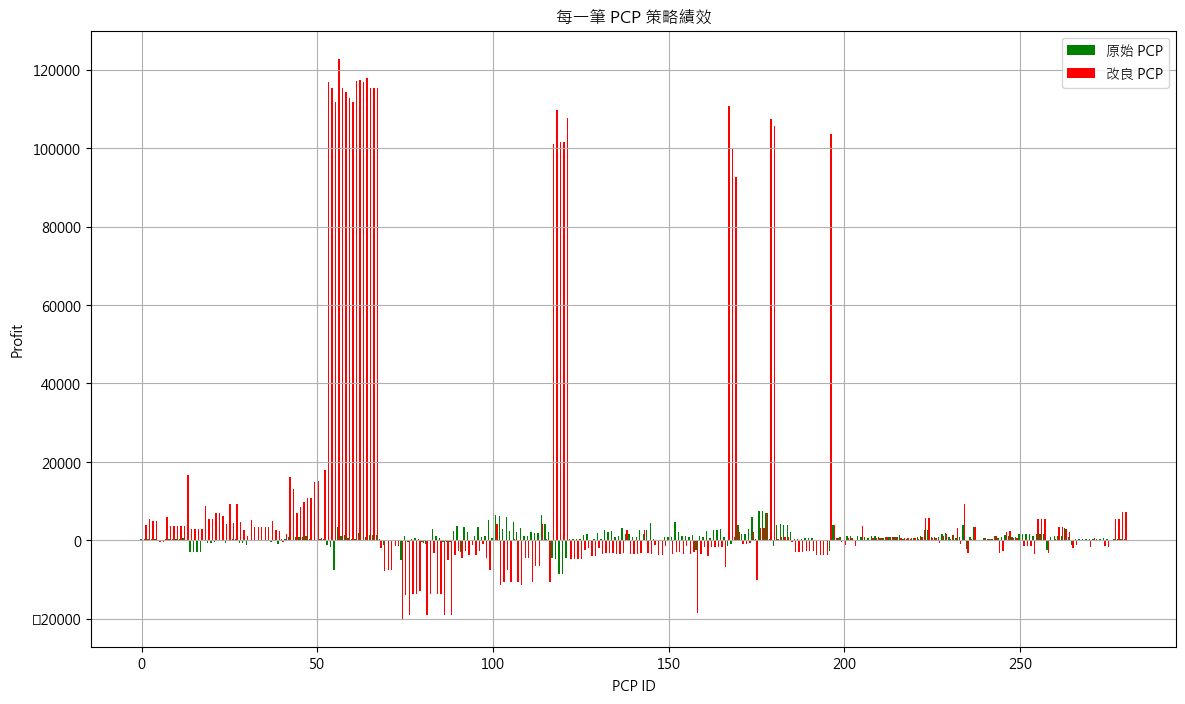

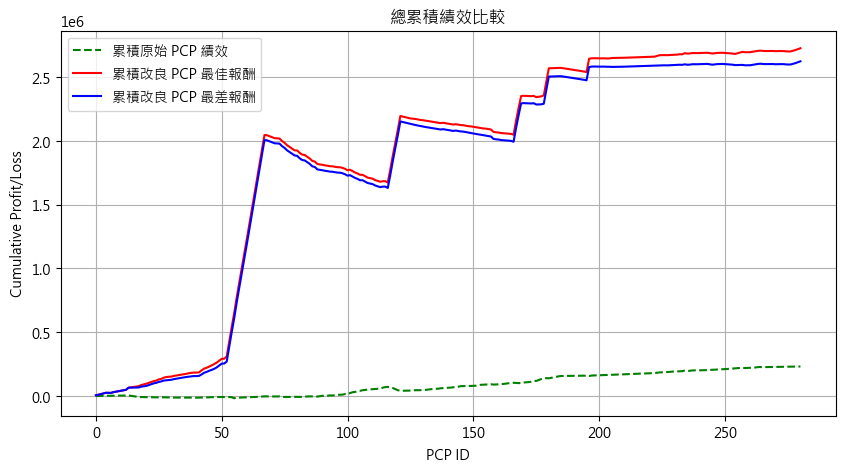

ÂéüÂßã PCP ÊúÄÁµÇÁ∏ΩÊêçÁõä: 231490.00
ÊîπËâØ PCP ÊúÄÁµÇÁ∏ΩÊêçÁõä(ÊúÄ‰Ω≥ÊÉÖÊ≥Å): 2726492.29
ÊîπËâØ PCP ÊúÄÁµÇÁ∏ΩÊêçÁõä(ÊúÄÂ∑ÆÊÉÖÊ≥Å): 2623992.29
ÊúÄ‰Ω≥ÊÉÖÊ≥ÅÁç≤Âà©: 2495002.29
ÊúÄÂ∑ÆÊÉÖÊ≥ÅÁç≤Âà©: 2392502.29


In [314]:
def plot_pcp_performance(df_pcp_results):
    """
    Ë¶ñË¶∫Âåñ PCP Á≠ñÁï•Á∏æÊïàÔºå‰∏¶Ë®àÁÆóÊúÄÁµÇÁöÑÁ∏ΩÊêçÁõäÔºö
    1. ÊØè‰∏ÄÁ≠Ü PCP Á≠ñÁï•ÁöÑÁ∏æÊïàÂ∑ÆÁï∞ÔºàBar ChartÔºâ
    2. Á∏ΩÁ¥ØÁ©çÁ∏æÊïàÔºàLine ChartÔºâ
    3. Ë®àÁÆó‰∏¶ÊâìÂç∞ÊúÄÁµÇÁ∏ΩÊêçÁõä
    """

    # **ÊèêÂèñÁ∏æÊïàÊï∏Êìö**
    pcp_ids = df_pcp_results["PCP_ID"]
    max_profit_origin = df_pcp_results["Max Profit Origin"]
    max_profit_final = df_pcp_results["Max Profit Final"]
    max_loss_final = df_pcp_results["Max Loss Final"]

    # **Ë®àÁÆóÁ¥ØÁ©çÁ∏æÊïà**
    cumulative_profit_origin = np.cumsum(max_profit_origin)
    cumulative_profit_final = np.cumsum(max_profit_final.fillna(0))  # ÈÅøÂÖç NaN
    cumulative_loss_final = np.cumsum(max_loss_final.fillna(0))  # ÈÅøÂÖç NaN

    # **üìä ÊØè‰∏ÄÁ≠Ü PCP Á≠ñÁï•Á∏æÊïà**
    plt.figure(figsize=(14, 8))
    width = 0.4  # Ë®≠ÂÆöÊü±ÁãÄÂúñÂØ¨Â∫¶
    plt.bar(pcp_ids - width/2, max_profit_origin, width=width, label="ÂéüÂßã PCP", color="green")
    plt.bar(pcp_ids + width/2, max_profit_final, width=width, label="ÊîπËâØ PCP", color="red")
    plt.title("ÊØè‰∏ÄÁ≠Ü PCP Á≠ñÁï•Á∏æÊïà")
    plt.xlabel("PCP ID")
    plt.ylabel("Profit")
    plt.legend()
    plt.grid(True)
    plt.show()

    # **üìà Á∏ΩÁ¥ØÁ©çÁ∏æÊïà**
    plt.figure(figsize=(10, 5))
    plt.plot(pcp_ids, cumulative_profit_origin, label="Á¥ØÁ©çÂéüÂßã PCP Á∏æÊïà", linestyle="dashed", color="green")
    plt.plot(pcp_ids, cumulative_profit_final, label="Á¥ØÁ©çÊîπËâØ PCP ÊúÄ‰Ω≥Â†±ÈÖ¨", linestyle="solid", color="red")
    plt.plot(pcp_ids, cumulative_loss_final, label="Á¥ØÁ©çÊîπËâØ PCP ÊúÄÂ∑ÆÂ†±ÈÖ¨", linestyle="solid", color="blue")
    plt.title("Á∏ΩÁ¥ØÁ©çÁ∏æÊïàÊØîËºÉ")
    plt.xlabel("PCP ID")
    plt.ylabel("Cumulative Profit/Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # **üîπ Ë®àÁÆóÊúÄÁµÇÁ∏ΩÊêçÁõä**
    total_profit_origin = max_profit_origin.sum()
    total_profit_final = max_profit_final.sum()
    total_loss_final = max_loss_final.sum()

    print(f"ÂéüÂßã PCP ÊúÄÁµÇÁ∏ΩÊêçÁõä: {total_profit_origin:.2f}")
    print(f"ÊîπËâØ PCP ÊúÄÁµÇÁ∏ΩÊêçÁõä(ÊúÄ‰Ω≥ÊÉÖÊ≥Å): {total_profit_final:.2f}")
    print(f"ÊîπËâØ PCP ÊúÄÁµÇÁ∏ΩÊêçÁõä(ÊúÄÂ∑ÆÊÉÖÊ≥Å): {total_loss_final:.2f}")
    print(f"ÊúÄ‰Ω≥ÊÉÖÊ≥ÅÁç≤Âà©: {total_profit_final - total_profit_origin:.2f}")
    print(f"ÊúÄÂ∑ÆÊÉÖÊ≥ÅÁç≤Âà©: {total_loss_final - total_profit_origin:.2f}")

# **‰ΩøÁî®ÁØÑ‰æã**
plot_pcp_performance(df_pcp_results)


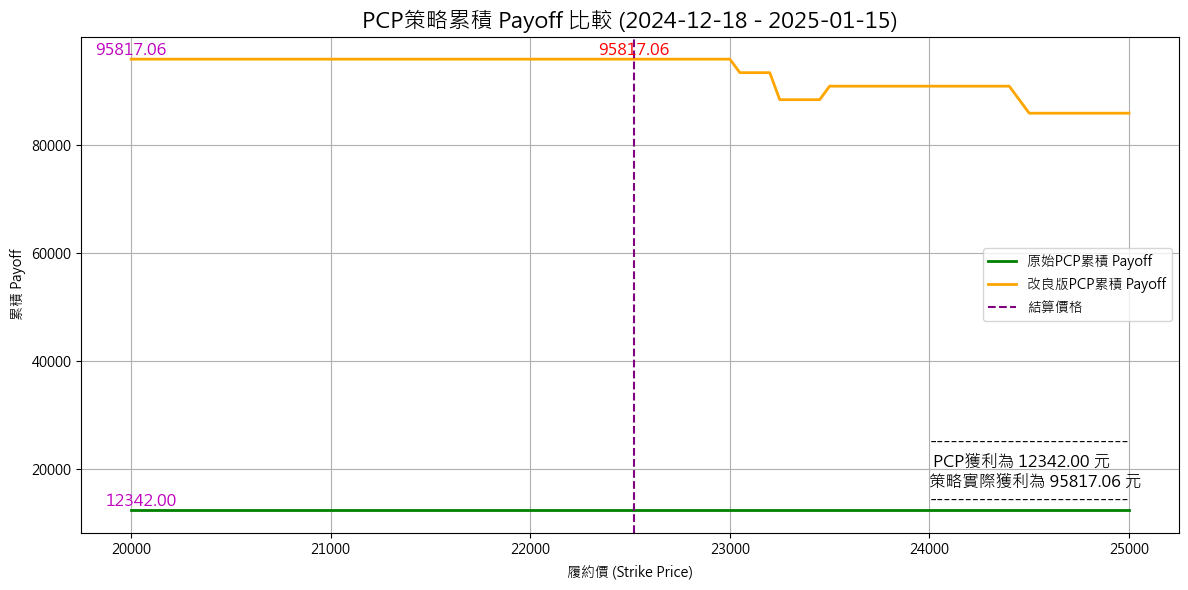

In [178]:
def plot_pcp_accumulated_payoff_by_date(df_origin, df_final, asset_low, asset_high, settlement_price, start_date, end_date):
    """
    Ê†πÊìöÊó•ÊúüÁØÑÂúçÔºåË®àÁÆó‰∏¶Áπ™Ë£ΩÂéüÂßã PCP ËàáÊîπËâØÁâà PCP Á¥ØÁ©ç Payoff Êõ≤Á∑öÔºå
    ‰∏¶Âú®Âúñ‰∏≠Ê®ôÁ§∫ÊúÄÁµÇÁ∏ΩÁç≤Âà©Ë≥áË®ä„ÄÇ
    """

    # **1. Â∞áËº∏ÂÖ•Êó•ÊúüËΩâÊèõÁÇ∫ datetime Ê†ºÂºè**
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # **2. Á¢∫‰øù DataFrame ÁöÑÊó•ÊúüÊ¨Ñ‰ΩçÊòØ datetime**
    df_origin['Date'] = pd.to_datetime(df_origin['Date'])
    df_final['Date'] = pd.to_datetime(df_final['Date'])

    # **3. Ê†πÊìöÊó•ÊúüÁØÑÂúçÈÅéÊøæÊï∏Êìö**
    df_origin_filtered = df_origin[(df_origin['Date'] >= start_date) & (df_origin['Date'] <= end_date)]
    df_final_filtered = df_final[(df_final['Date'] >= start_date) & (df_final['Date'] <= end_date)]

    # **4. Ê™¢Êü•ÊòØÂê¶ÊúâÁØ©ÈÅ∏Âà∞Êï∏Êìö**
    if df_origin_filtered.empty or df_final_filtered.empty:
        print("‚ö†Ô∏è ÁØ©ÈÅ∏ÂæåÁöÑÊï∏ÊìöÁÇ∫Á©∫ÔºåË´ãÊ™¢Êü•Êó•ÊúüÁØÑÂúçÊòØÂê¶Ê≠£Á¢∫ÔºÅ")
        return

    # **5. ÂÆöÁæ©Â±•Á¥ÑÂÉπÁØÑÂúç**
    strike_range = np.arange(asset_low, asset_high + 1, step=50)  # ‰ΩøÁî®Ê≠•ÈÄ≤ÂÄºÈôç‰ΩéÊï∏ÊìöÈáè

    # **6. ÂàùÂßãÂåñÁ¥ØÁ©ç Payoff Êõ≤Á∑ö**
    accumulated_origin_payoff = np.zeros_like(strike_range, dtype=np.float64)
    accumulated_final_payoff = np.zeros_like(strike_range, dtype=np.float64)

    # **7. Ë®àÁÆóÂéüÂßã PCP Á≠ñÁï•ÁöÑ Payoff**
    for _, row in df_origin_filtered.iterrows():
        strike = row['StrikePrice']
        call_price = row['CallPrice']
        put_price = row['PutPrice']
        future_price = row['FuturePrice']
        fee_origin1 = row['NewFee']
        fee_settlement1 = row['SettlementFee']
        future_bs = row['FutureBS']

        # Á¢∫‰øùÊï∏ÊìöÈùû NaN
        if pd.isna(strike) or pd.isna(call_price) or pd.isna(put_price) or pd.isna(future_price):
            continue

        # **Ë®àÁÆó Payoff**
        if future_bs == 'S':  # BC + SP + SF
            payoff_origin_call = 50 * (strike_range - strike).clip(min=0) - 50*call_price
            payoff_origin_put = -50 * (strike - strike_range).clip(min=0) + 50*put_price
            payoff_origin_future = -50 * (strike_range - future_price)
        else:  # BP + SC + BF
            payoff_origin_call = -50 * (strike_range - strike).clip(min=0) + 50*call_price
            payoff_origin_put = 50 * (strike - strike_range).clip(min=0) - 50*put_price
            payoff_origin_future = 50 * (strike_range - future_price)

        payoff_origin_total = (payoff_origin_call + payoff_origin_put + payoff_origin_future) - fee_origin1 - fee_settlement1
        accumulated_origin_payoff += payoff_origin_total

    # **8. Ë®àÁÆóÊîπËâØÁâà PCP Á≠ñÁï•ÁöÑ Payoff**
    for _, row in df_final_filtered.iterrows():
        call_strike = row['Call_Strike']
        put_strike = row['Put_Strike']
        call_price = row['CallPrice']
        put_price = row['PutPrice']
        future_price = row['FuturePrice']
        fee_origin2 = row['NewFee']
        fee_settlement2 = row['SettlementFee']
        strategy_type = row['ArbitrageStrategy']

        # Á¢∫‰øùÊï∏ÊìöÈùû NaN
        if pd.isna(call_strike) or pd.isna(put_strike) or pd.isna(call_price) or pd.isna(put_price) or pd.isna(future_price):
            continue

        # **Ë®àÁÆóÊîπËâØÁâà Payoff**
        if strategy_type == 'SP':  # BC + SP + SF
            payoff_final_call = 50 * (strike_range - call_strike).clip(min=0) - 50*call_price
            payoff_final_put = -50 * (put_strike - strike_range).clip(min=0) + 50*put_price
            payoff_final_future = -50 * (strike_range - future_price)
        elif strategy_type == 'SC':  # BP + SC + BF
            payoff_final_put = 50 * (put_strike - strike_range).clip(min=0) - 50*put_price
            payoff_final_call = -50 * (strike_range - call_strike).clip(min=0) + 50*call_price
            payoff_final_future = 50 * (strike_range - future_price)
        else:
            print(f"‚ùå Êú™Áü•Á≠ñÁï•: {strategy_type}")
            return None

        payoff_final_total = (payoff_final_call + payoff_final_put + payoff_final_future) - fee_origin2 - fee_settlement2
        accumulated_final_payoff += payoff_final_total

    # **9. Ë®àÁÆóÊúÄÁµÇÁ∏ΩÊêçÁõä**
    total_profit_origin = accumulated_origin_payoff.max()
    total_profit_final = accumulated_final_payoff.max()
    total_loss_final = accumulated_final_payoff.min()
    
    # **ÈÄèÈÅéÁµêÁÆóÂÉπÊ†ºÂÅµÊ∏¨ÊîπËâØÁâàPCPÁöÑÁç≤Âà©**
    settlement_index = np.argmin(np.abs(strike_range - settlement_price))
    strategy_actual_profit = accumulated_final_payoff[settlement_index]

    # **10. Áπ™Ë£ΩÁ¥ØÁ©ç Payoff Êõ≤Á∑ö**
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.plot(strike_range, accumulated_origin_payoff, label='ÂéüÂßãPCPÁ¥ØÁ©ç Payoff', color='green', linewidth=2)
    plt.plot(strike_range, accumulated_final_payoff, label='ÊîπËâØÁâàPCPÁ¥ØÁ©ç Payoff', color='orange', linewidth=2)
    plt.axvline(x=settlement_price, color='purple', linestyle='dashed', label='ÁµêÁÆóÂÉπÊ†º')
     
    # **Ê®ôË®ªÊúÄÂ∞èÁç≤Âà©**
    min_profit_index = np.argmin(total_loss_final)
    max_profit_index = np.argmax(accumulated_final_payoff)
    max_profit_value = accumulated_final_payoff[max_profit_index]
    plt.text(strike_range[min_profit_index] , accumulated_final_payoff[min_profit_index], f'{accumulated_final_payoff[min_profit_index]:.2f}', fontsize=12, ha='center', va='bottom', color='m')
    #plt.text(strike_range[max_profit_index] , max_profit_value, f' {max_profit_value:.2f}', fontsize=12, ha='center', va='bottom', color='blue')

    # **Ê®ôË®ªÁ≠ñÁï•ÂØ¶ÈöõÁç≤Âà©**
    plt.text(settlement_price , accumulated_final_payoff[settlement_index] + 100, f'{accumulated_final_payoff[settlement_index]:.2f}', fontsize=12, ha='center', va='bottom', color='red')

    # **Ê®ôË®ªPCPÁç≤Âà©ÔºàÂúñÁâáÂ∑¶ÂÅ¥Ôºâ**
    plt.text(asset_low + 50, min(accumulated_origin_payoff), f'{min(accumulated_origin_payoff):.2f}', fontsize=12, ha='center', va='bottom', color='m')

    # **Ê®ôË®ªPCPËàáÁ≠ñÁï•ÁöÑÊúÄÁµÇÁç≤Âà©**
    plt.text(asset_high - 1000, total_profit_origin   , f'----------------------------\n PCPÁç≤Âà©ÁÇ∫ {total_profit_origin:.2f} ÂÖÉ\nÁ≠ñÁï•ÂØ¶ÈöõÁç≤Âà©ÁÇ∫ {strategy_actual_profit:.2f} ÂÖÉ\n----------------------------', fontsize=12, ha='left', va='bottom', color='black')

    # **Ë®≠ÂÆöÊ®ôÈ°åËàáÊ®ôÁ±§**
    plt.title(f'PCPÁ≠ñÁï•Á¥ØÁ©ç Payoff ÊØîËºÉ ({start_date.date()} - {end_date.date()})', fontsize=16)
    plt.xlabel('Â±•Á¥ÑÂÉπ (Strike Price)')
    plt.ylabel('Á¥ØÁ©ç Payoff')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}"))  # Á¢∫‰øùË≤†ËôüËÉΩÊ≠£Â∏∏È°ØÁ§∫
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pcp_accumulated_payoff_by_date(
    df_origin=df_origin_pcp2,
    df_final=df_final_pcp2,
    asset_low=20000,
    asset_high=25000,
    settlement_price=22519,
    start_date='2024-12-18',  # Ëµ∑ÂßãÊó•Êúü
    end_date='2025-01-15'     # ÁµêÊùüÊó•Êúü
)



In [315]:
def plot_pcp_accumulated_payoff_by_date(df_origin, df_final, asset_low, asset_high, settlement_price, start_date, end_date):
    """
    Ê†πÊìöÊó•ÊúüÁØÑÂúçÔºåË®àÁÆó‰∏¶Áπ™Ë£ΩÂéüÂßã PCP ËàáÊîπËâØÁâà PCP Á¥ØÁ©ç Payoff Êõ≤Á∑öÔºå
    ‰∏¶Âú®Âúñ‰∏≠Ê®ôÁ§∫ÊúÄÁµÇÁ∏ΩÁç≤Âà©Ë≥áË®äÂèäÊúÄ‰Ωé Payoff Êï∏ÂÄº„ÄÇ
    """

    # **1. Â∞áËº∏ÂÖ•Êó•ÊúüËΩâÊèõÁÇ∫ datetime Ê†ºÂºè**
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # **2. Á¢∫‰øù DataFrame ÁöÑÊó•ÊúüÊ¨Ñ‰ΩçÊòØ datetime**
    df_origin['Date'] = pd.to_datetime(df_origin['Date'])
    df_final['Date'] = pd.to_datetime(df_final['Date'])

    # **3. Ê†πÊìöÊó•ÊúüÁØÑÂúçÈÅéÊøæÊï∏Êìö**
    df_origin_filtered = df_origin[(df_origin['Date'] >= start_date) & (df_origin['Date'] <= end_date)]
    df_final_filtered = df_final[(df_final['Date'] >= start_date) & (df_final['Date'] <= end_date)]

    # **4. Ê™¢Êü•ÊòØÂê¶ÊúâÁØ©ÈÅ∏Âà∞Êï∏Êìö**
    if df_origin_filtered.empty or df_final_filtered.empty:
        print("‚ö†Ô∏è ÁØ©ÈÅ∏ÂæåÁöÑÊï∏ÊìöÁÇ∫Á©∫ÔºåË´ãÊ™¢Êü•Êó•ÊúüÁØÑÂúçÊòØÂê¶Ê≠£Á¢∫ÔºÅ")
        return

    # **5. ÂÆöÁæ©Â±•Á¥ÑÂÉπÁØÑÂúç**
    strike_range = np.arange(asset_low, asset_high + 1, step=50)  # ‰ΩøÁî®Ê≠•ÈÄ≤ÂÄºÈôç‰ΩéÊï∏ÊìöÈáè

    # **6. ÂàùÂßãÂåñÁ¥ØÁ©ç Payoff Êõ≤Á∑ö**
    accumulated_origin_payoff = np.zeros_like(strike_range, dtype=np.float64)
    accumulated_final_payoff = np.zeros_like(strike_range, dtype=np.float64)

    # **7. Ë®àÁÆóÂéüÂßã PCP Á≠ñÁï•ÁöÑ Payoff**
    for _, row in df_origin_filtered.iterrows():
        strike = row['StrikePrice']
        call_price = row['CallPrice']
        put_price = row['PutPrice']
        future_price = row['FuturePrice']
        fee_origin1 = row['NewFee']
        fee_settlement1 = row['SettlementFee']
        future_bs = row['FutureBS']

        # Á¢∫‰øùÊï∏ÊìöÈùû NaN
        if pd.isna(strike) or pd.isna(call_price) or pd.isna(put_price) or pd.isna(future_price):
            continue

        # **Ë®àÁÆó Payoff**
        if future_bs == 'S':  # BC + SP + SF
            payoff_origin_call = 50 * (strike_range - strike).clip(min=0) - 50*call_price
            payoff_origin_put = -50 * (strike - strike_range).clip(min=0) + 50*put_price
            payoff_origin_future = -50 * (strike_range - future_price)
        else:  # BP + SC + BF
            payoff_origin_call = -50 * (strike_range - strike).clip(min=0) + 50*call_price
            payoff_origin_put = 50 * (strike - strike_range).clip(min=0) - 50*put_price
            payoff_origin_future = 50 * (strike_range - future_price)

        payoff_origin_total = (payoff_origin_call + payoff_origin_put + payoff_origin_future) - fee_origin1 - fee_settlement1
        accumulated_origin_payoff += payoff_origin_total

    # **8. Ë®àÁÆóÊîπËâØÁâà PCP Á≠ñÁï•ÁöÑ Payoff**
    for _, row in df_final_filtered.iterrows():
        call_strike = row['Call_Strike']
        put_strike = row['Put_Strike']
        call_price = row['CallPrice']
        put_price = row['PutPrice']
        future_price = row['FuturePrice']
        fee_origin2 = row['NewFee']
        fee_settlement2 = row['SettlementFee']
        strategy_type = row['ArbitrageStrategy']

        # Á¢∫‰øùÊï∏ÊìöÈùû NaN
        if pd.isna(call_strike) or pd.isna(put_strike) or pd.isna(call_price) or pd.isna(put_price) or pd.isna(future_price):
            continue

        # **Ë®àÁÆóÊîπËâØÁâà Payoff**
        if strategy_type == 'SP':  # BC + SP + SF
            payoff_final_call = 50 * (strike_range - call_strike).clip(min=0) - 50*call_price
            payoff_final_put = -50 * (put_strike - strike_range).clip(min=0) + 50*put_price
            payoff_final_future = -50 * (strike_range - future_price)
        elif strategy_type == 'SC':  # BP + SC + BF
            payoff_final_put = 50 * (put_strike - strike_range).clip(min=0) - 50*put_price
            payoff_final_call = -50 * (strike_range - call_strike).clip(min=0) + 50*call_price
            payoff_final_future = 50 * (strike_range - future_price)
        else:
            print(f"‚ùå Êú™Áü•Á≠ñÁï•: {strategy_type}")
            return None

        payoff_final_total = (payoff_final_call + payoff_final_put + payoff_final_future) - fee_origin2 - fee_settlement2
        accumulated_final_payoff += payoff_final_total

    # **9. Ë®àÁÆóÊúÄÁµÇÁ∏ΩÊêçÁõä**
    total_profit_origin = accumulated_origin_payoff.max()
    total_profit_final = accumulated_final_payoff.max()
    total_loss_final = accumulated_final_payoff.min()
    
    # **ÈÄèÈÅéÁµêÁÆóÂÉπÊ†ºÂÅµÊ∏¨ÊîπËâØÁâàPCPÁöÑÁç≤Âà©**
    settlement_index = np.argmin(np.abs(strike_range - settlement_price))
    strategy_actual_profit = accumulated_final_payoff[settlement_index]

    # **10. Áπ™Ë£ΩÁ¥ØÁ©ç Payoff Êõ≤Á∑ö**
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.plot(strike_range, accumulated_origin_payoff, label='ÂéüÂßãPCPÁ¥ØÁ©ç Payoff', color='green', linewidth=2)
    plt.plot(strike_range, accumulated_final_payoff, label='ÊîπËâØÁâàPCPÁ¥ØÁ©ç Payoff', color='orange', linewidth=2)
    plt.axvline(x=settlement_price, color='purple', linestyle='dashed', label='ÁµêÁÆóÂÉπÊ†º')
    
    # **Ê®ôË®ªÊúÄ‰Ωé Payoff**
    min_profit_index = np.argmin(accumulated_final_payoff)
    min_profit_value = accumulated_final_payoff[min_profit_index]
    max_profit_index = np.argmax(accumulated_final_payoff)
    max_profit_value = accumulated_final_payoff[max_profit_index]
    plt.text(strike_range[min_profit_index], min_profit_value, f'{min_profit_value:.2f}', fontsize=12, ha='center', va='bottom', color='blue')
    plt.text(strike_range[max_profit_index]  , max_profit_value, f' {max_profit_value:.2f}', fontsize=12, ha='center', va='bottom', color='blue')

    # **Ê®ôË®ªÁ≠ñÁï•ÂØ¶ÈöõÁç≤Âà©**
    plt.text(settlement_price, accumulated_final_payoff[settlement_index] + 100, f'{strategy_actual_profit:.2f}', fontsize=12, ha='center', va='bottom', color='red')
    
     # **Ê®ôË®ªPCPÁç≤Âà©ÔºàÂúñÁâáÂ∑¶ÂÅ¥Ôºâ**
    plt.text(asset_low + 50, min(accumulated_origin_payoff), f'{min(accumulated_origin_payoff):.2f}', fontsize=12, ha='center', va='bottom', color='m')
    # **Ê®ôË®ªPCPÁç≤Âà©**
    plt.text(asset_high - 500, total_profit_origin, f'PCPÁç≤Âà©: {total_profit_origin:.2f} ÂÖÉ\nÁ≠ñÁï•ÂØ¶ÈöõÁç≤Âà©: {strategy_actual_profit:.2f} ÂÖÉ', fontsize=12, ha='left', va='bottom', color='black')

    # **Ë®≠ÂÆöÊ®ôÈ°åËàáÊ®ôÁ±§**
    plt.title(f'PCPÁ≠ñÁï•Á¥ØÁ©ç Payoff ÊØîËºÉ ({start_date.date()} - {end_date.date()})', fontsize=16)
    plt.xlabel('Â±•Á¥ÑÂÉπ (Strike Price)')
    plt.ylabel('Á¥ØÁ©ç Payoff')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}"))  # Á¢∫‰øùË≤†ËôüËÉΩÊ≠£Â∏∏È°ØÁ§∫
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


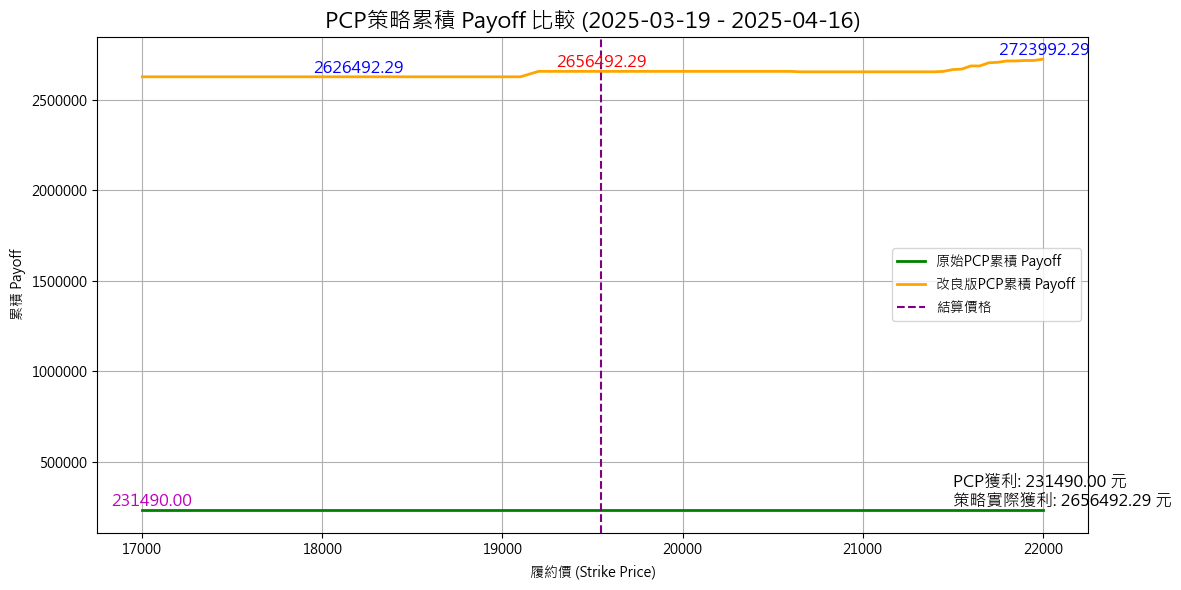

In [316]:
plot_pcp_accumulated_payoff_by_date(
    df_origin=df_origin_pcp2,
    df_final=df_final_pcp2,
    asset_low=17000,
    asset_high=22000,
    settlement_price=19548,
    start_date='2025-03-19',  # Ëµ∑ÂßãÊó•Êúü
    end_date='2025-04-16'     # ÁµêÊùüÊó•Êúü
)